In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import patsy
from IPython.display import HTML
import statsmodels

plt.style.use('seaborn-paper')
pd.options.display.max_columns = 150
_chars_per_line = 117

# Many thanks to lucacerone and harshil for their contribution to StackOverflow.
html_script = '''<script>code_show=true;function code_toggle(){if (code_show){
 $('div.input').hide();}else{$('div.input').show();}code_show = !code_show}
 $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()">
 <input type="submit" value="Click here to toggle on/off the raw code."></form>'''

def code_toggle(): return HTML(html_script.replace('true','false'))
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


<right><img src="https://thetomatos.com/wp-content/uploads/2016/02/house-clipart-vector-graphics-house-eps-clip-art-vector.jpg" style=" margin: 15px; height: 120px"></right>


## Project 1:  Regression and classification with housing data

### Goals:

There are three goals this project seeks to achive from a technical perspective:

    1. To create a predictive model for the sale price of a property based on its "fixed" and "known" characteristics.
    2. To create a predictive model for sale price of a property as a function of its "alterable" qualities.
    3. To determine the features in the housing data that best predict "abnormal" sales.

Furthermore, in service to the reader (and ourselves) we seek to:

    I.   Present the data, methods and assumptions we are working with in a clear and explicit manner.
    II.  Justify the decicions we make towards the development of our model, and its evaluation.
    
In this project we will be working with the Ames housing data set that consists of records detailing 1460 sales of various properties from 2006 to 2010 in the city of Ames, Iowa.


In [3]:
class GlobalHelper:
    
    global immutable_replace
    def immutable_replace(entry,dictionary = {}):
        if entry in dictionary.keys():
            return dictionary[entry]
        else:
            return entry 
        
    global immutable_replace_with_unknowns
    def immutable_replace_with_unknowns(ser, dictionary, unknown = 'CouldNotBeInferred'):
        pass
        

    global scale_dataframe
    def scale_dataframe(df, method = 'StandardScaler'):
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        scaler.fit(df)
        return pd.DataFrame(columns=df.columns,data=scaler.transform(df))
    
    global plist
    def plist(list_to_print = [], spacing = 14, col_num = 8, title = False):
        '''Prints a list in a pretty way'''
        list_items = [str(item).ljust(spacing) for item in list_to_print]
        if title:print(title+':\n{}'.format('_'*_chars_per_line))
        for i in range(0,len(list_to_print),col_num): 
            [print(list_items[j],end='') for j in range(i,i+col_num) if j < len(list_to_print)]
            print()

    global extended_type
    def extended_type(x):
        if x != x:
            return "<class 'missing'>"
        else:
            return str(type(x))

    global get_m_n
    def get_m_n(N):
        '''find m,n such that an m*n grid can hold N values in a pleasing way'''
        for m in range(int(np.ceil(np.sqrt(N))),N+1):
            for k in range(0,m):
                A = m**2 + m*k
                B = m/2 -1 + m**2 -k*m - m
                if B < N and A >= N: 
                    return (m,m-k)

In [4]:
class DataFrameHelper(pd.DataFrame):
    
    history = []
    
    def set_checkpoint(self):
        self.history.append('set_checkpoint')
        self.checkpoint = self
   
    def reset(self):
        try:
            self.history.append('reset')
            self = self.checkpoint
        except:
            self.history.append('reset failed')
            print('reseting failed')
            

    def explore_types(self, columns = None):      
        if columns == None: columns = self.columns
        
        di = {key:self[key].apply(extended_type).value_counts() for key in columns}
        return pd.DataFrame(columns = columns, data = di)
    
    def pcolumns(self,columns = None, spacing = 14, col_num = 8):
        '''Prints the column names in a pretty way. 
        The default is to print all columns, but a list may be passed.'''
        if columns == None: columns = self.columns
        plist(columns, spacing, col_num)
    
    def puniques(self,columns, spacing=7,col_num=16):
        for col in columns:
            print(col+':\n{}'.format('_'*115))
            plist(self[col].unique(), spacing=spacing,col_num=col_num)
            print()
    
    def plot_value_occurences(self,normed = False, columns = None, 
                              fig_size = (15,15), xmarks = False,mn = None, verbose = 0):
        if columns == None: columns = self.columns.tolist()
            
        num_of_cols = len(columns)
        if verbose > 0: print('Generating ',num_of_cols,' plots')
        if mn == None:
            m,n = get_m_n(num_of_cols)
        else:
            m,n = mn
        
        plt.clf()
        plt.figure(figsize=fig_size)
        plt.suptitle('Histogram of unique values',fontsize=25)
        
        for i in range(num_of_cols):
            col = columns[i]
            plt.subplot(m,n,i+1)
            plt.title(col)
            self[col].value_counts(dropna = False).plot(kind='bar');
            if xmarks == False: plt.xticks([])
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        return None
    
    def plot_poly_regplot(self,target,deg = 1, columns = None, 
                              fig_size = (15,15), xmarks = False,mn = None,
                              low = False):
        if columns == None: columns = self.describe().columns.tolist()
            
        num_of_cols = len(columns)
        print('Generating ',num_of_cols,' plots')
        if mn == None:
            m,n = get_m_n(num_of_cols)
        else:
            m,n = mn
        
        plt.clf()
        plt.figure(figsize=fig_size)
        plt.suptitle('Polynomial fit of unique values',fontsize=25)
        
        for i in range(num_of_cols):
            try:
                col = columns[i]
                plt.subplot(m,n,i+1)
                plt.title(col)
                sns.regplot(self[col],self[target], order = deg, lowess= low)
                if xmarks == False: plt.xticks([])
            except:
                print('Something went wrong while exploring {}'.format(columns[i]))
                pass
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        return None
    
    def plot_types(self, columns = None, split = 4, figsize = (17,2)):
        _ = plt.clf();
        _ = self.explore_types(columns = columns).T.plot(kind='bar',figsize=figsize, stacked=True, legend=None);
        _ = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.);
        _ = plt.suptitle('Occurence of types in attributes',fontsize=25);
        _ = plt.subplots_adjust(top=0.80);
        _ = plt.show();
        return None
        

In [5]:
class ProjectHelper(DataFrameHelper):
    '''This Class is hard coded for this project. Its methods are useful for data cleaning.'''
    
    #definition of essentialy nessesary data cleaning
    def impute_typos(self):
        COPY = self.copy()
        COPY.history.append('impute_typos')
        COPY.loc[948,'BsmtExposure'] = 'No'
        COPY.loc[332,'BsmtFinType2'] = 'Unf'
        COPY.loc[1379,'Electrical'] = 'SBrkr'
        return COPY
    
    def impute_correct_type_to_MSSubClass(self):
        self.history.append('impute_correct_type_to_MSSubClass')
        
        MSSubClass_dict ={
            20:'1-STORY 1946 & NEWER ALL STYLES',
            30:'1-STORY 1945 & OLDER',
            40:'1-STORY W/FINISHED ATTIC ALL AGES',
            45:'1-1/2 STORY - UNFINISHED ALL AGES',
            50:'1-1/2 STORY FINISHED ALL AGES',
            60:'2-STORY 1946 & NEWER',
            70:'2-STORY 1945 & OLDER',
            75:'2-1/2 STORY ALL AGES',
            80:'SPLIT OR MULTI-LEVEL',
            85:'SPLIT FOYER',
            90:'DUPLEX - ALL STYLES AND AGES',
            120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
            150:'1-1/2 STORY PUD - ALL AGES',
            160:'2-STORY PUD - 1946 & NEWER',
            180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
            190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}
        
        self['MSSubClass'] = self['MSSubClass'].apply(lambda x: immutable_replace(x,MSSubClass_dict))

    def impute_0_to_nan(self):
        '''We impute 0 to nan for every occurence in some columns (because 0 is a suitable value of an area)'''
        self.history.append('impute_0_to_nan')
        
        for col in ['LotFrontage','MasVnrArea']:
            self[col].fillna(value = 0,inplace=True)
    
    def impute_None_to_nan(self):
        '''We impute the string 'None' to nan (because no such feature is present)'''
        
        self.history.append('impute_None_to_nan')
        for col in ['Alley','MasVnrType','BsmtFinType2','GarageType','PoolQC','Fence','MiscFeature']:
            self[col].fillna(value = 'None',inplace=True)
    
    def impute_NotApplicable_to_nan(self):
        '''We impute 'NotApplicable' to nan (because this is an atribute of a feature that is not present)'''
        self.history.append('impute_NotApplicable_to_nan')
        
        for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','FireplaceQu','GarageYrBlt',
                    'GarageFinish','GarageQual','GarageCond']:
            self[col].fillna(value = 'NotApplicable',inplace=True)
        
        
  
    # Perform the above imputation methods one after another.
    def impute(self):
        self.history.append('impute...')
        self.impute_typos()
        self.impute_correct_type()
        self.impute_0_to_nan()
        self.impute_None_to_nan()
        self.impute_NotApplicable_to_nan()
    
    #definition of 'optional' data cleaning
    def cast_quality_to_numbers(self,NA = 0):
        self.history.append('cast_quality_to_numbers')
        quality_to_number_dict = {
           'Ex':5,
           'Gd':4,
           'TA':3,
           'Fa':2,
           'Po':1,
           'NA':NA,
           'NotApplicable': NA}
        
        for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']:
            self[col] = self[col].apply(lambda x: immutable_replace(x,quality_to_number_dict))
    
    def cast_land_slope_to_numbers(self):
        self.history.append('cast_land_slope_to_numbers')
        LandSlope_dict = {
           'Gtl':0, #Gentle slope
           'Mod':1, #Moderate Slope
           'Sev':2} #Severe Slope
        self['LandSlope'] = self['LandSlope'].apply(lambda x: immutable_replace(x,LandSlope_dict))       
    
    #definition of methods for quality of life improvements.
    def get_years(self,LIST = [2010]):
        if not isinstance(LIST,list): LIST = [LIST]
        mask = [True if x in LIST else False for x in self['YrSold']]
        return self[mask]
    

In [6]:
class ModelingReport:
    def __init__(self,model,X,y,naive_score,cv_score,true_score):
        self.model = model
        self.X = X
        self.y = y 
        self.naive_score = naive_score
        self.cv_score = cv_score
        self.true_score = true_score
        self.stored_settings = None
    
    def to_df(self):
        rec = pd.DataFrame(columns=['report', 'model','naive_score','true_score','cv_score'],
                           data={'report':self,'model':self.model,'naive_score':self.naive_score,
                                 'cv_score':self.cv_score,'true_score':self.true_score},index = ['rec:'])
        
        if self.stored_settings != None:
            settings = pd.DataFrame(self.stored_settings,index=['rec:'])
            rec = pd.concat([rec,settings],axis=1)
        return rec
    
    def remember_config(self,di):
        self.stored_settings = di

In [7]:
def implement_modeling(
    df,
    target = 'SalePrice',
    ignore_colums = None,
    consider_columns = None,
    
    model='lm',
    model_alpha = 1,
    
    get_dummies = True, 
    dummy_columns = None,
    do_drop_first = False,
    

    scale_technique = None):
    
    '''This function performs most actions that would normaly be associated to implementing 
    and assessing a regression model.
    
    it returns an object called model_report that contains 
    the key elements of the implementation and assesment as atributes.
    
    The model_report contains as atributes the model and feature matrix 
    so that further exploration can be done with ease'''
    
    try:
        test = (df['YrSold'] == 2010).values
        train = (df['YrSold'] != 2010).values
    except:
        pass
    
    X = df.drop([target],axis=1)
    y = df[target]
    
    # using specific colums or ignoring others
    if consider_columns != None:
        X = X[consider_columns]
    if ignore_colums != None:
        X = X.drop([col for col in ignore_colums if col in X.columns],axis = 1)
    
    # Select a model and initialize it with the appropiate hyperparameters
    if model == 'lm':
        model = LinearRegression()
    elif model == 'ridge':
        model = Ridge(alpha = model_alpha)
    elif model == 'lasso':
        model = Lasso(alpha = model_alpha)

    # Get dummie variables
    # This will dummify columns if you specify them, or dummify all non numeric columns if you do not
    
    if get_dummies == True or dummy_columns != None:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = pd.get_dummies(data = X,columns = dummy_columns, drop_first=do_drop_first)
        X.columns = [col.replace(' ','_') for col in X.columns]
    else:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = X.drop(dummy_columns,axis=1)

    # Perform scaling
    
    if scale_technique != None:
        X = scaler(X,scale_technique)
        
    ''' # model fitting and evaluation: 
    model.fit(X,y)
    
    naive_score = model.score(X,y)
    cv_score = r2_score(y,cross_val_predict(model,X,y))
    
    model.fit(X[train],y[train])
    true_score = model.score(X[test],y[test])
    
    gs = 
    
    model_report = ModelingReport(model,X,y,naive_score,cv_score,true_score)
    
    model_report.remember_config({'alpha':model_alpha,'scaling':scale_technique,
                                  'get_dummies':get_dummies,'features':X.shape[1]})
    
    return model_report'''

    return (X,y)

In [119]:
def getXy(
    df,
    target = 'SalePrice',
    ignore_colums = None,
    consider_columns = None,
    
    drop_col_if_contains_nan = True,
    
    cast_into_other = [],
    
    get_dummies = True, 
    dummy_columns = None,
    do_drop_first = False,
    
    scale_technique = None,
    train_test = False):
    
    '''This function performs most actions that would normaly be associated to preparing 
    a frature and target matrix for procesing'''
    
    try:
        test = (df['YrSold'] == 2010).values
        train = (df['YrSold'] != 2010).values
    except:
        pass
    
    X = df.drop([target],axis=1)
    y = df[target]
    
    # using specific colums or ignoring others
    if consider_columns != None:
        X = X[consider_columns]
    if ignore_colums != None:
        X = X.drop([col for col in ignore_colums if col in X.columns],axis = 1)

    # drop columns or rows when a a missing value is found.
    if drop_col_if_contains_nan:
        X = X.dropna(how = 'any',axis = 1)
    else:
        X = X.dropna(how = 'any',axis = 0)
        
    # Perform a map from old values to new values on specific columns.
    for col,di in cast_into_other:
        X[col] = X[col].apply(lambda x: immutable_replace(x,di))

    # Get dummie variables: This will dummify columns if you specify them, 
    # or dummify all non numeric columns if you do not specify any.
    
    if get_dummies == True or dummy_columns != None:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = pd.get_dummies(data = X,columns = dummy_columns, drop_first=do_drop_first)
        X.columns = [col.replace(' ','_') for col in X.columns]
    else:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = X.drop(dummy_columns,axis=1)

    # Perform scaling
    if scale_technique != None:
        X = dataframe_scaler(X,scale_technique)

    if train_test == True:
        return (X[train],X[test],y[train],y[test])
    return (X,y)

<right><img src="https://images.vexels.com/media/users/3/143466/isolated/preview/b47bfb19d11e66c3be00ccb0632047ce-lupa-simples-by-vexels.png" style=" margin: 15px; height: 120px"></right>

### 1. Examining and Cleaning the data 

Of the 1460 records, 1450 pertain to the sale of residential properties. We focus soley on these, since ultimately we have neither the interest, nor a suficient amount of data to build a reliable model for non-residential properties.

<a href="https://git.generalassemb.ly/raw/DSI-LDN-3/lessons-repo/master/projects/project-02/data_description.txt?token=AAAY4q6W44WqbDLYg_WJiPApoQi-l2qrks5ZeROlwA%3D%3D" target="_blank">Feature Descriptions</a>

In [9]:
data_set = pd.read_csv('../../../lessons-repo/projects/project-02/housing.csv')
data_set.drop(['Id'],axis=1,inplace=True)

residential = data_set['MSZoning'].isin(['FV','RH','RL','RM'])

df = DataFrameHelper(data_set[residential])
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

The 80 features associated with a sale are:


In [10]:
df.pcolumns()

MSSubClass    MSZoning      LotFrontage   LotArea       Street        Alley         LotShape      LandContour   
Utilities     LotConfig     LandSlope     Neighborhood  Condition1    Condition2    BldgType      HouseStyle    
OverallQual   OverallCond   YearBuilt     YearRemodAdd  RoofStyle     RoofMatl      Exterior1st   Exterior2nd   
MasVnrType    MasVnrArea    ExterQual     ExterCond     Foundation    BsmtQual      BsmtCond      BsmtExposure  
BsmtFinType1  BsmtFinSF1    BsmtFinType2  BsmtFinSF2    BsmtUnfSF     TotalBsmtSF   Heating       HeatingQC     
CentralAir    Electrical    1stFlrSF      2ndFlrSF      LowQualFinSF  GrLivArea     BsmtFullBath  BsmtHalfBath  
FullBath      HalfBath      BedroomAbvGr  KitchenAbvGr  KitchenQual   TotRmsAbvGrd  Functional    Fireplaces    
FireplaceQu   GarageType    GarageYrBlt   GarageFinish  GarageCars    GarageArea    GarageQual    GarageCond    
PavedDrive    WoodDeckSF    OpenPorchSF   EnclosedPorch 3SsnPorch     ScreenPorch   PoolArea    

Soon we will clasify these properties as either:

    1. Fixed         (it would not be fesable to alter this attributes)
    2. Alterable     (it would be possible to alter this attributes)
    3. Incidental    (it is a property of the specific sale)
    4. Derivative    (it can be deduced to a high degree of accuracy from other properties)
    
But first we inspect our data for missing values and deal with them in a case-by-case basis.

#### 1.1 Verifying the quality of the data

We seek to identify and replace our missing values.

_classic_test


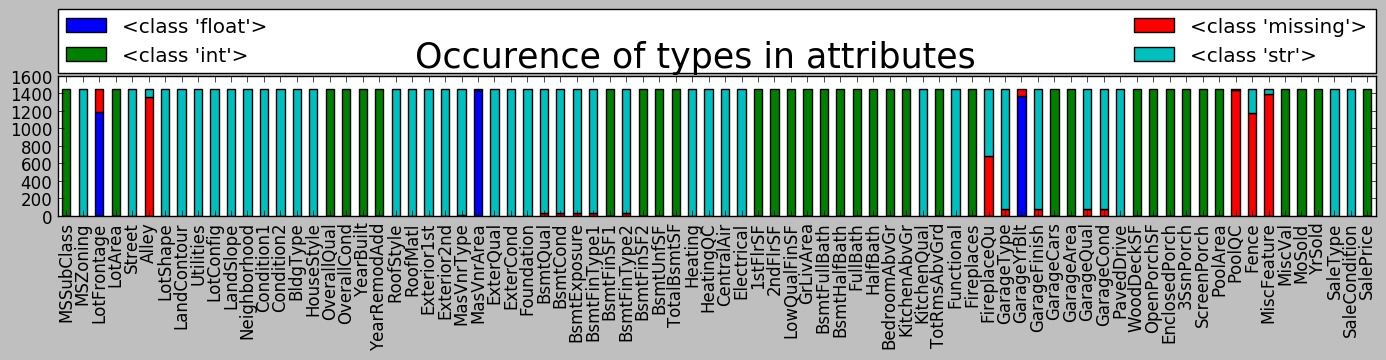

bmh


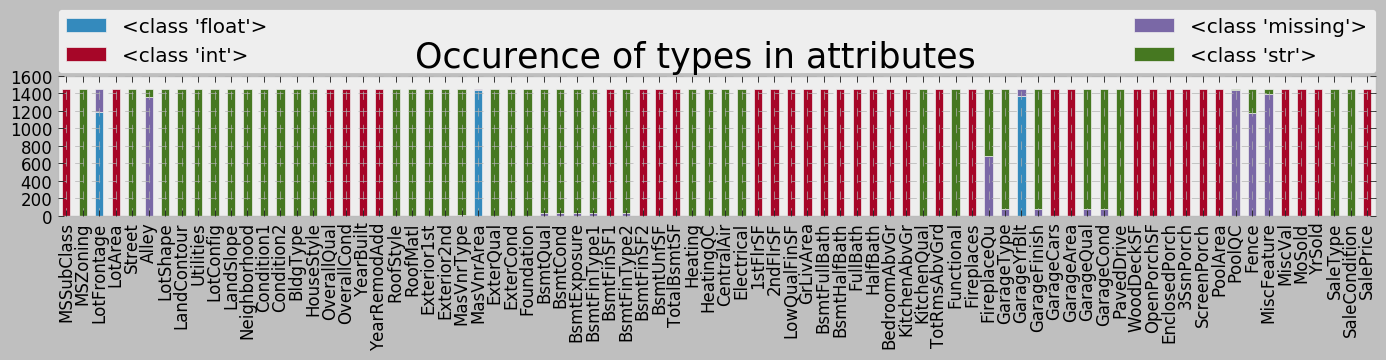

classic


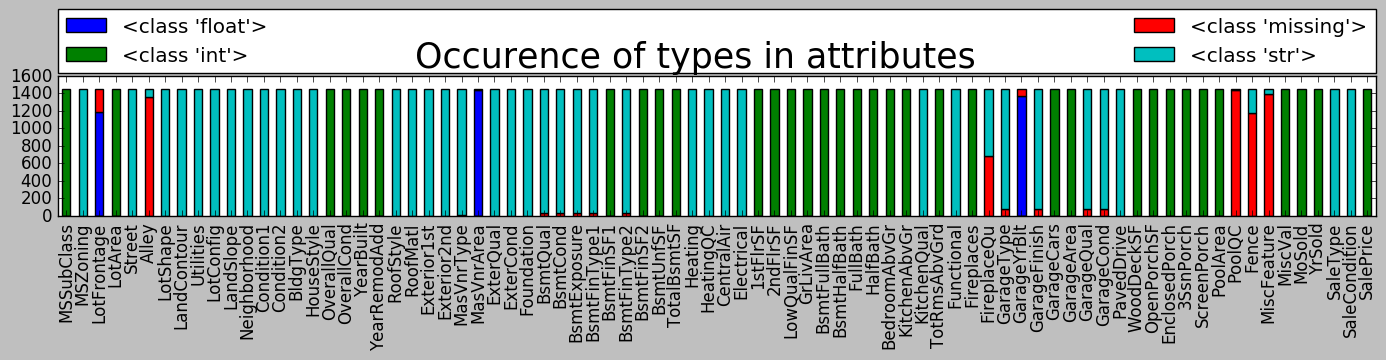

dark_background


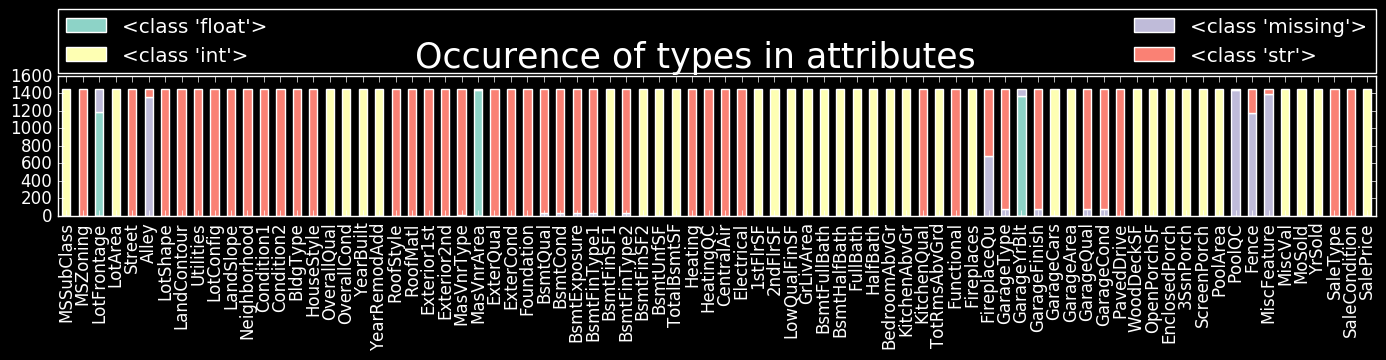

fivethirtyeight


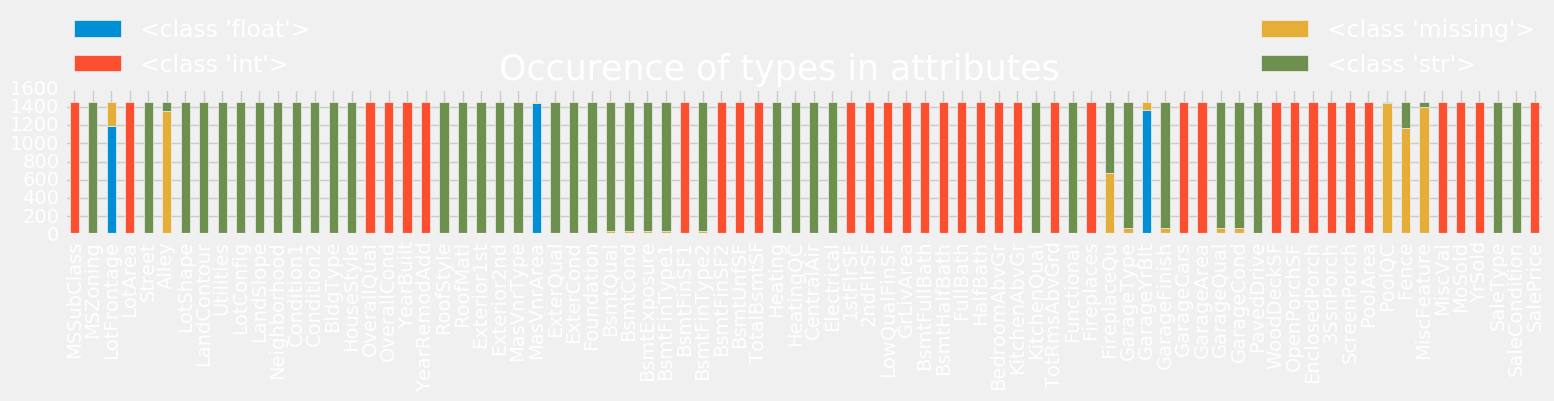

ggplot


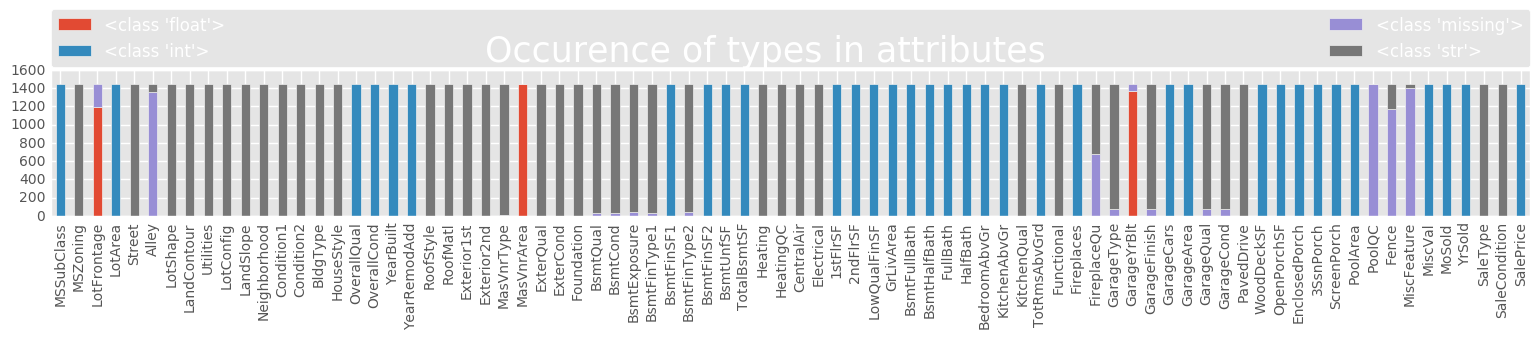

grayscale


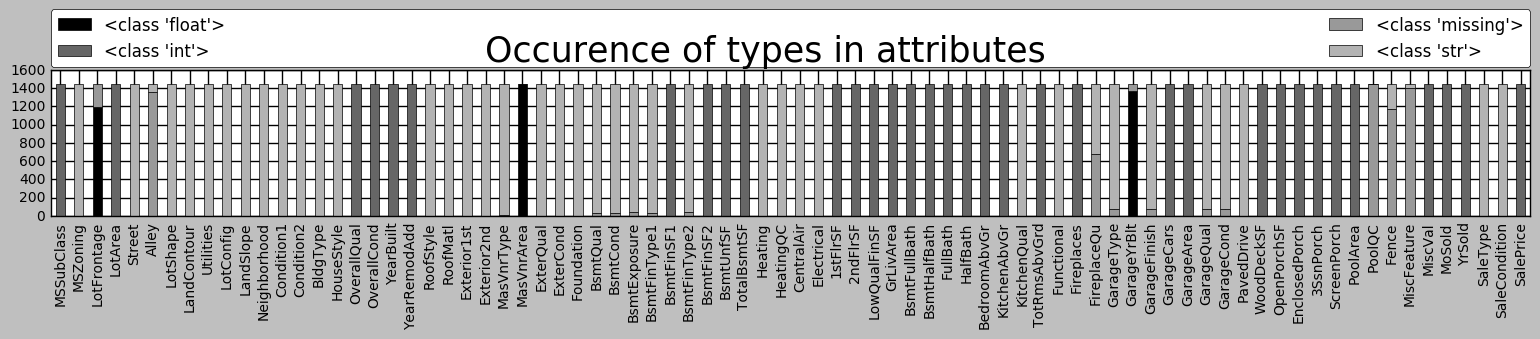

seaborn-bright


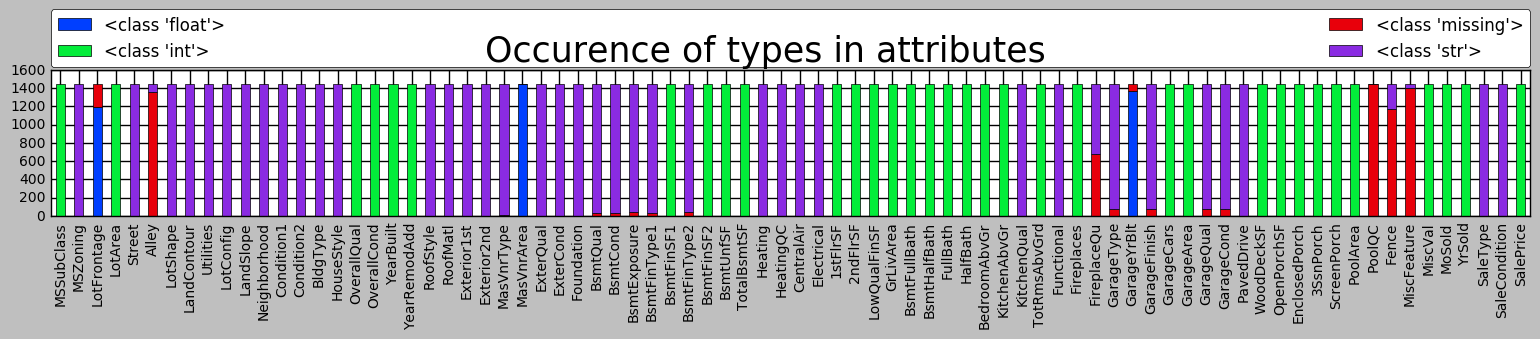

seaborn-colorblind


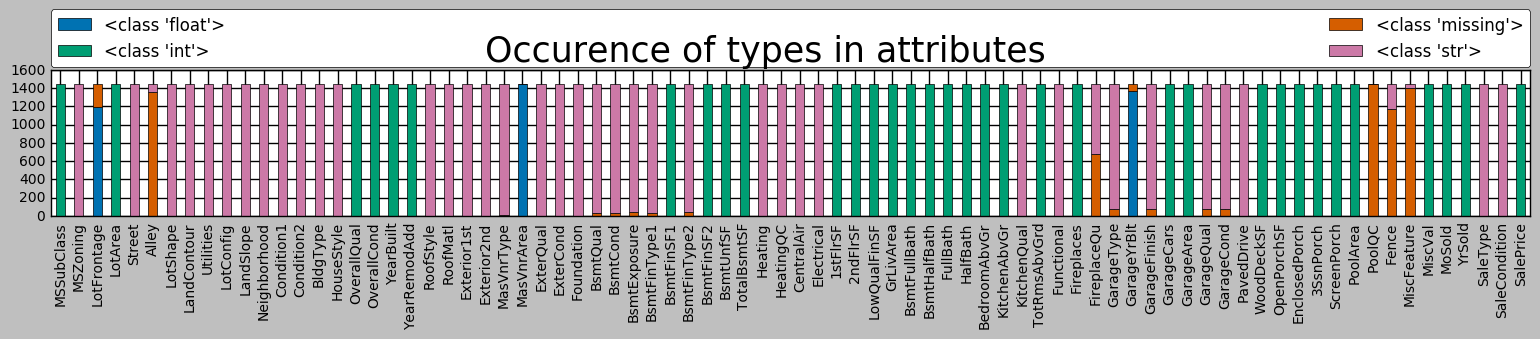

seaborn-dark-palette


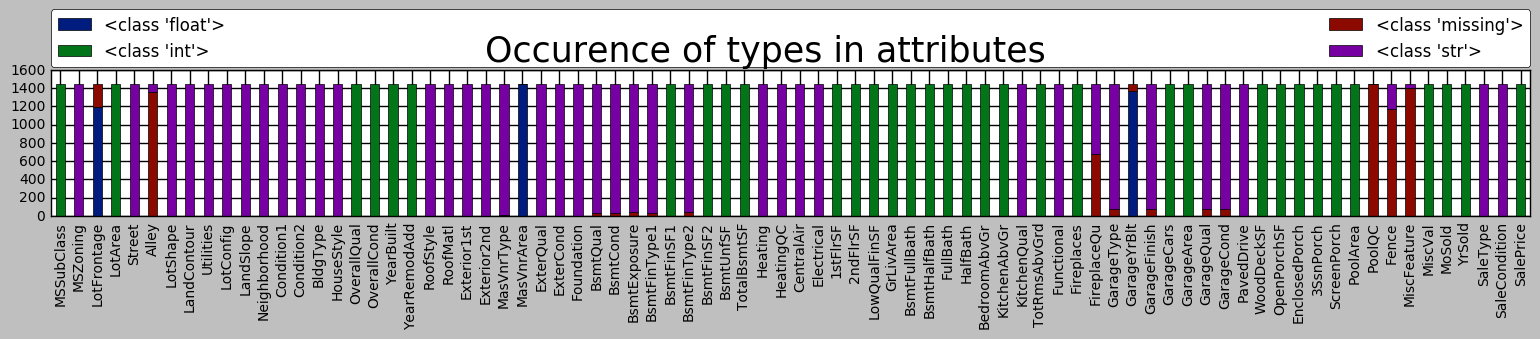

seaborn-dark


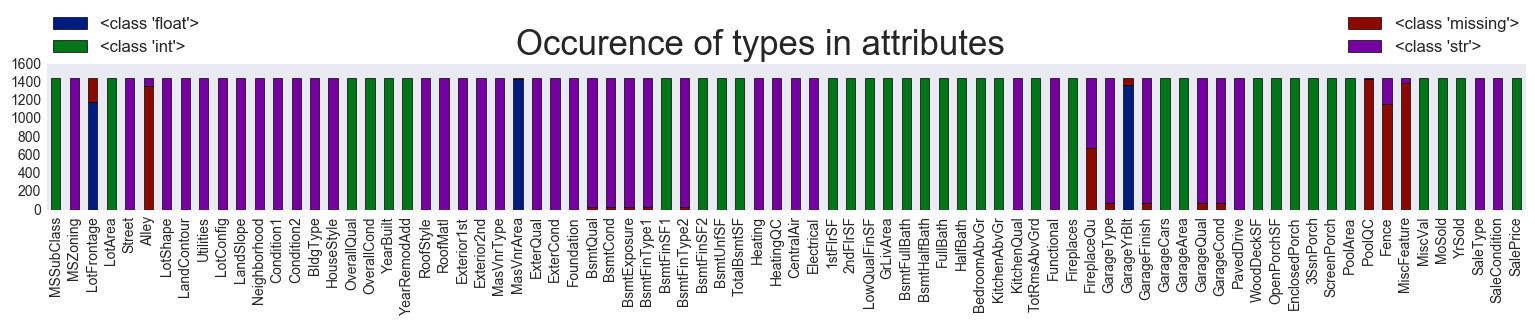

seaborn-darkgrid


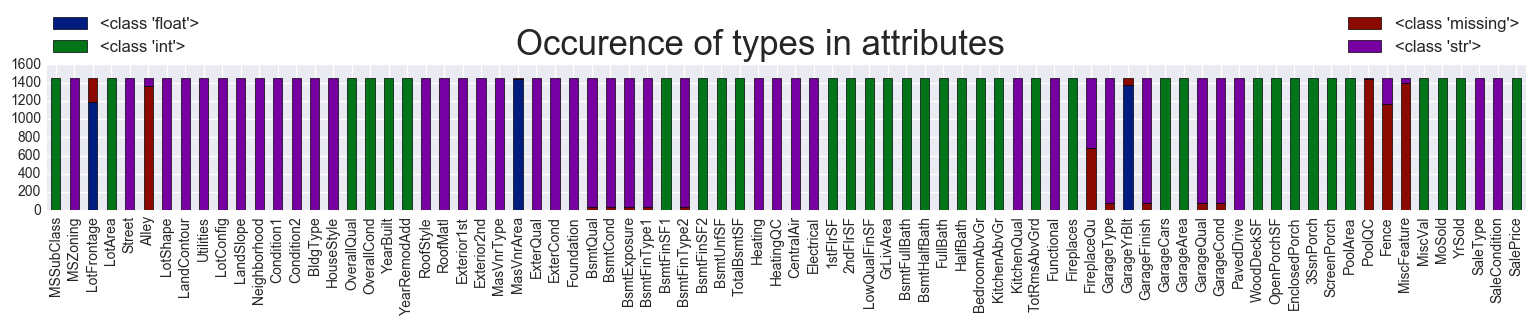

seaborn-deep


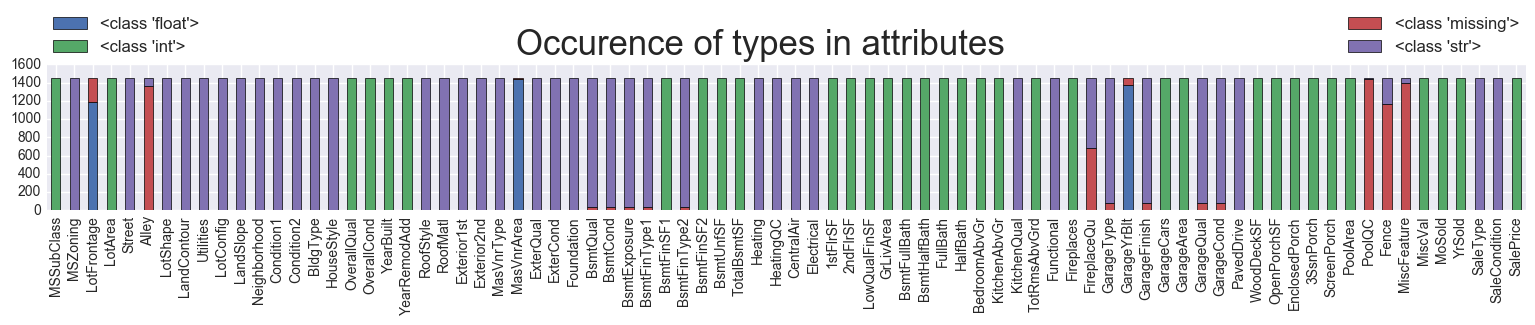

seaborn-muted


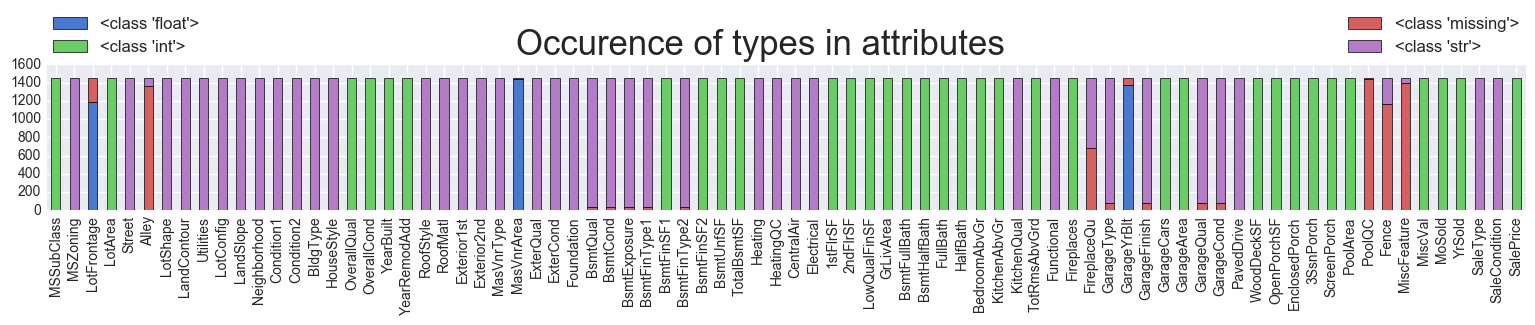

seaborn-notebook


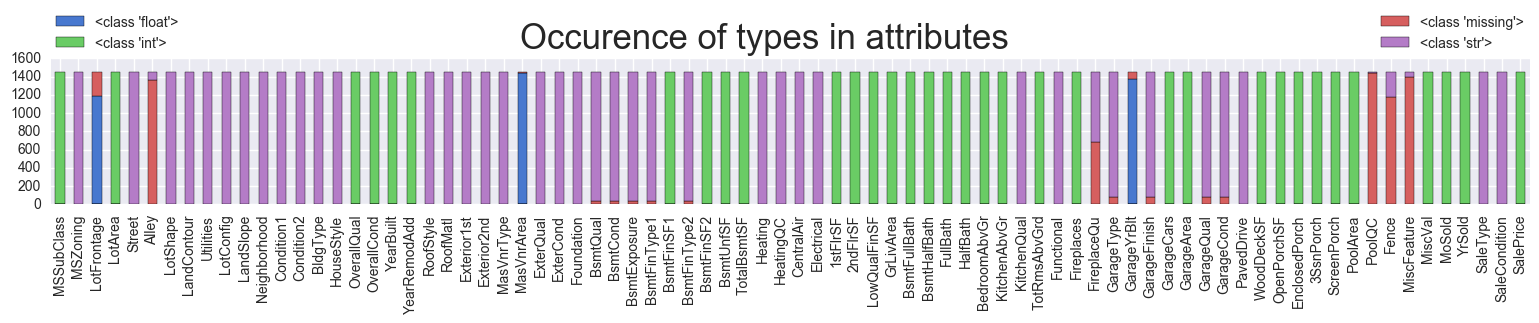

seaborn-paper


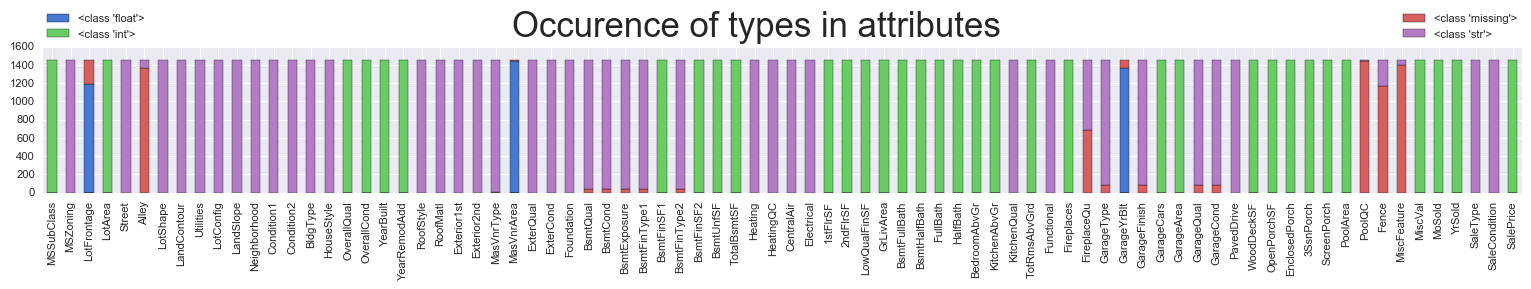

seaborn-pastel


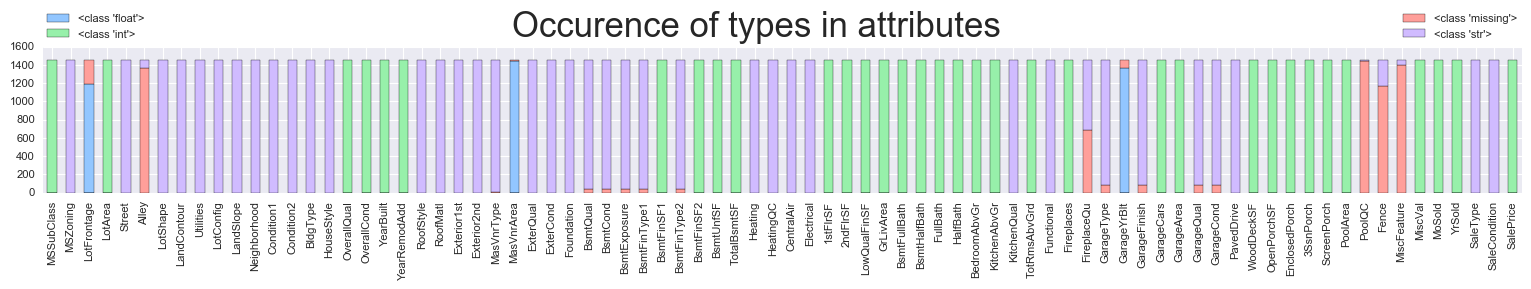

seaborn-poster


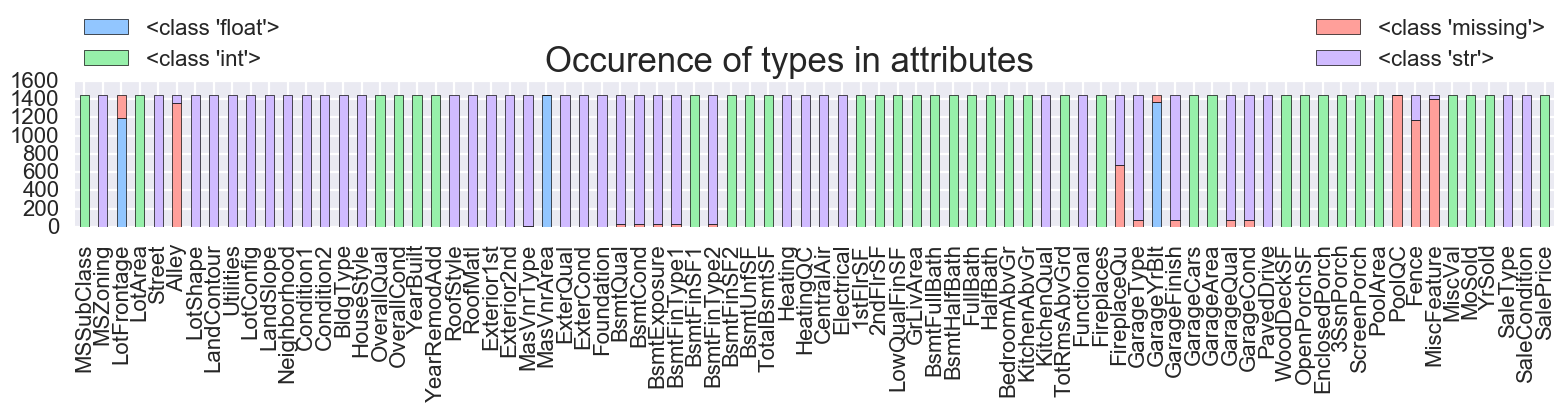

seaborn-talk


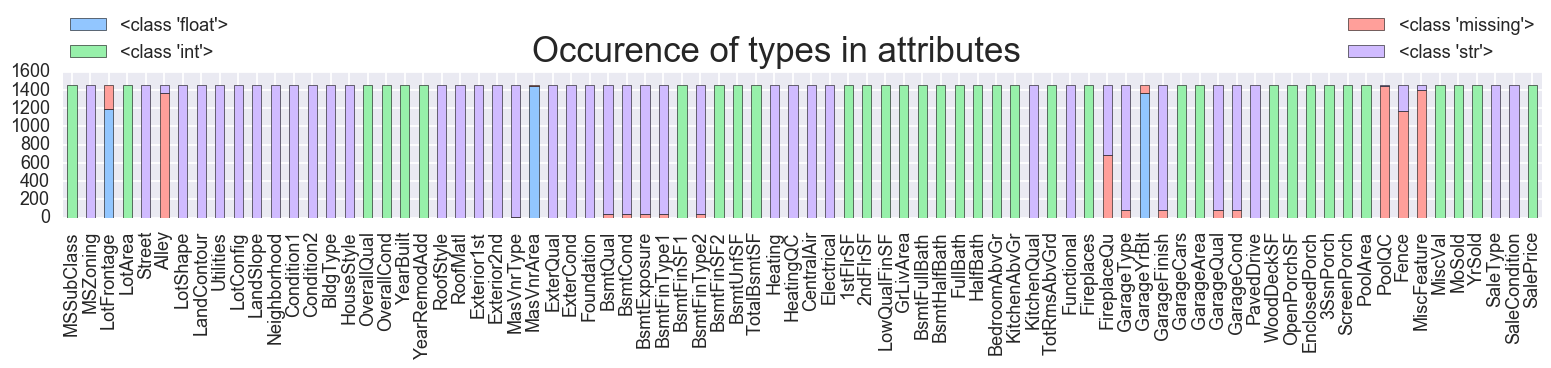

seaborn-ticks


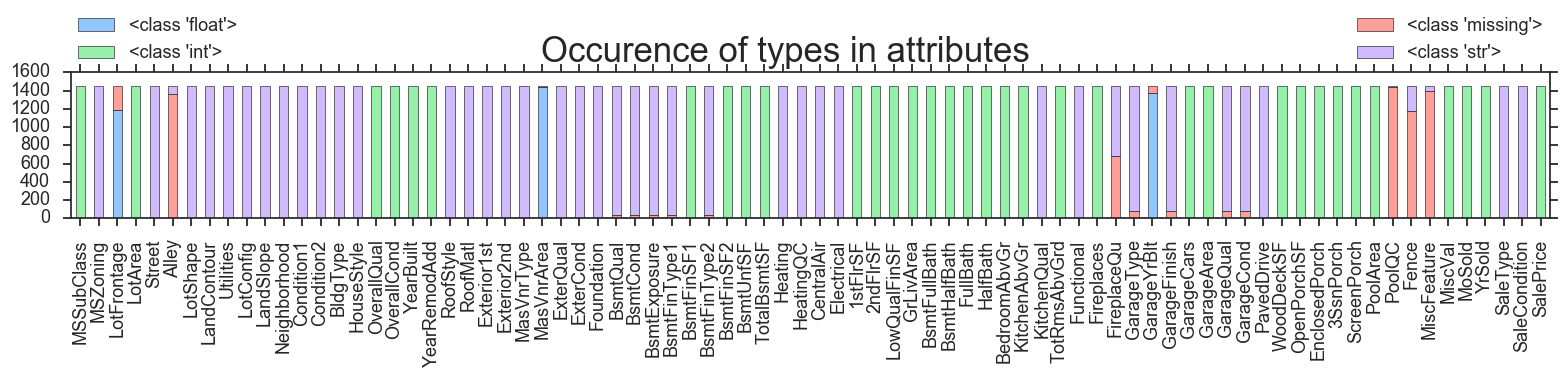

seaborn-white


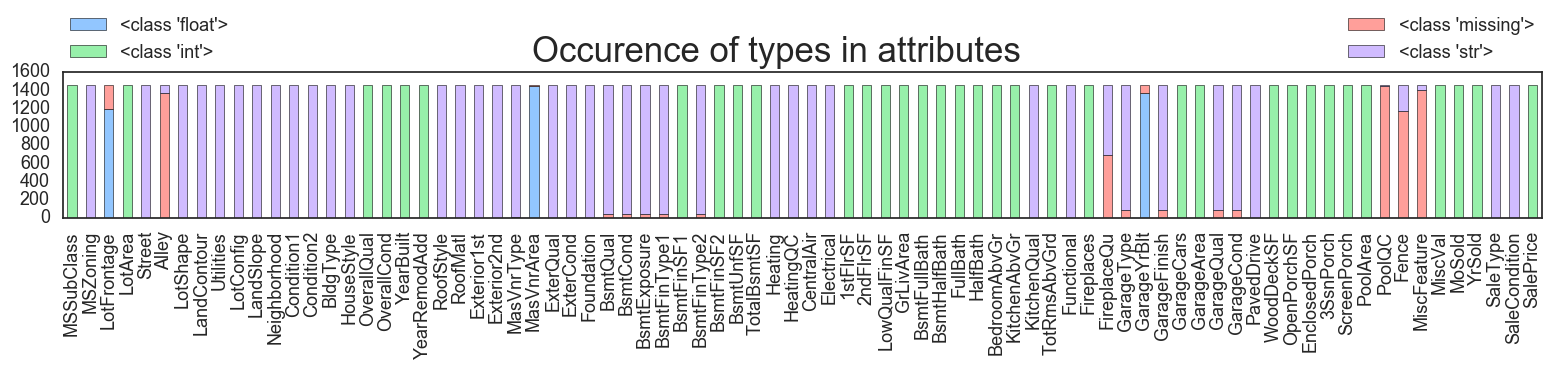

seaborn-whitegrid


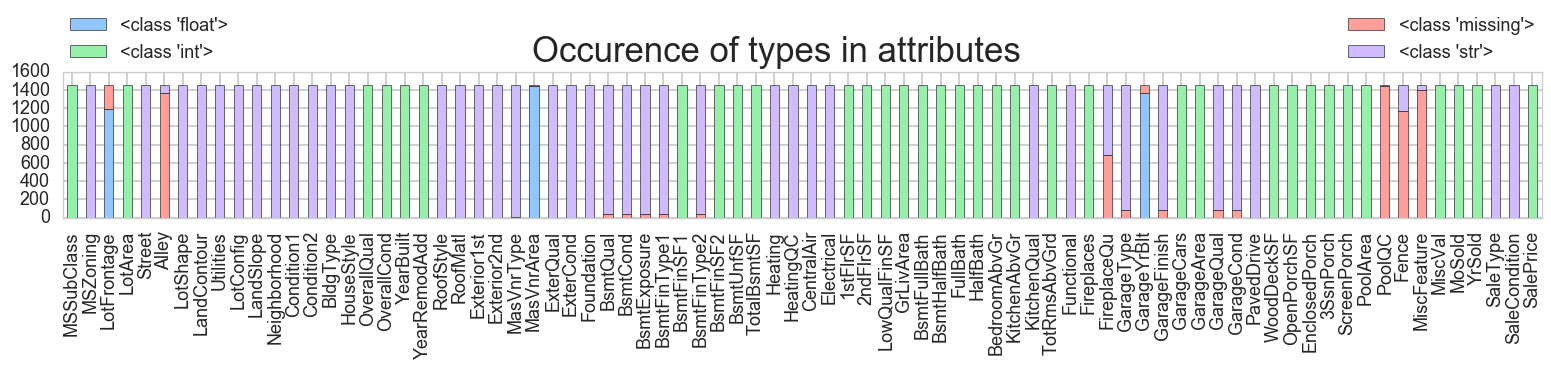

seaborn


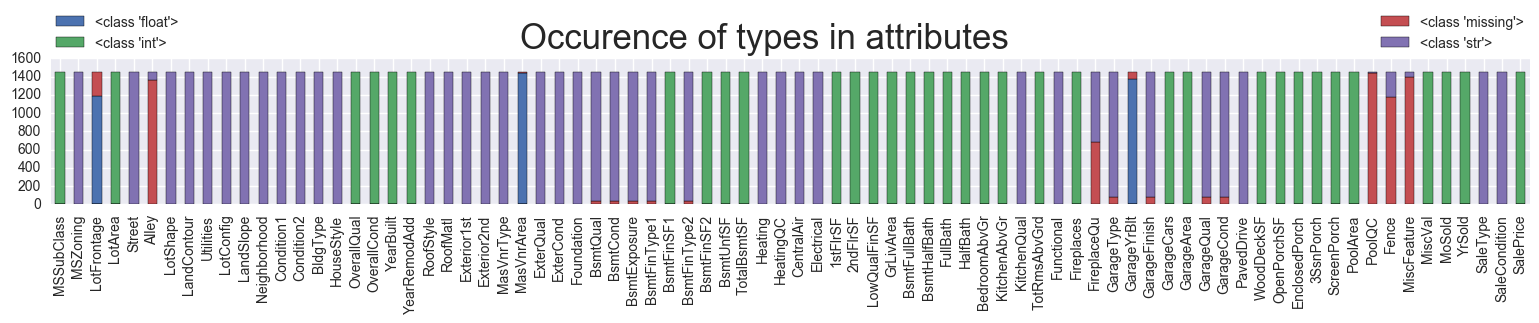

In [12]:
df.plot_types()

Our first concern is to handle the attributes with missing values. 

These are:

In [13]:
examine_closer = [col for col in df.columns if df[col].isnull().any()]
examine_closer_str = [col for col in examine_closer if df[col].apply(lambda x: isinstance(x,str)).any()]
examine_closer_num = [col for col in examine_closer if col not in examine_closer_str]
plist(examine_closer, title = 'Attributes with Missing Values')

Attributes with Missing Values:
_____________________________________________________________________________________________________________________
LotFrontage   Alley         MasVnrType    MasVnrArea    BsmtQual      BsmtCond      BsmtExposure  BsmtFinType1  
BsmtFinType2  Electrical    FireplaceQu   GarageType    GarageYrBlt   GarageFinish  GarageQual    GarageCond    
PoolQC        Fence         MiscFeature   


We start by taking a look at attributes where the entries that are present are strings.

We look at their unique values and the frequency of their incidence.

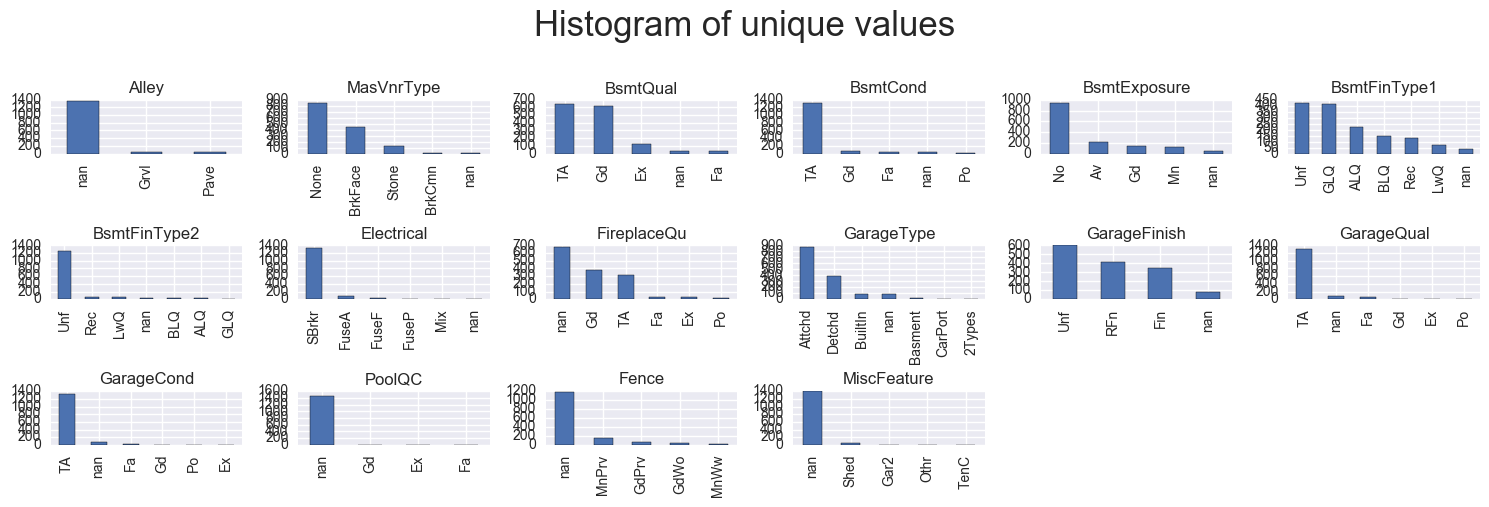

In [14]:
df.plot_value_occurences(columns = examine_closer_str,xmarks = True,fig_size=(15,15),mn=(10,6))

We notice many of these features are descriptors of other features, or of attributes of the house. In this context thethe 'NA' value in the housing.csv file that was used to indicate that a feature is not pressent. We replace these missing values with the string 'DescribesMissing'. We do this for 2 reasons:

    1. For many of these features we will end up using dummy variables, which do not 
       handle np.nan well, but can easily incoporate one more category. 
    
    2. We hope we can later inspect these values further perhaps as part of some feature egeneering.
       A descriptive entry will be helpful in conceptualising futher analysis.
    
The features for which we replace nan with 'DescriptorMissing' are: 

    BsmtQual      BsmtCond      BsmtExposure  BsmtFinType1  BsmtFinType2      FireplaceQu   
    GarageType    GarageFinish  GarageQual    GarageCond    PoolQC        

However, for:

    Alley         Fence         MiscFeature

we replace missing values with the string 'None' following the convention used in the describing the type of facade (MasVnrType). In describing the type of covering of the walls, they allow the abscense of any covering to be a valid covering kind in and of itself.


Regarding MasVnrType, and Elec itself:

we could replace nan with 'None', but this would amount to assuming data input errors. Rather than mofing forward with this assumption, we explore another possibility:

In [15]:
df[df['MasVnrType'].isnull()][['MasVnrType','SaleCondition','YearRemodAdd','YrSold']]

MasVnrType SaleCondition  YearRemodAdd  YrSold
234         NaN        Normal          2002    2010
529         NaN        Alloca          1975    2007
650         NaN        Normal          2007    2008
936         NaN        Normal          2003    2009
973         NaN       Partial          2008    2008
977         NaN       Partial          2007    2007
1243        NaN       Partial          2006    2006
1278        NaN        Normal          2002    2008

As we can see, 3 of the 8 properties with nan MasVnrType were only partialy built. It would be wrong to assume any one kind of verneer will be used (or intentionaly left with no veneer). Our plan is then to replace nan with "CouldNotBeInferred" in the understanding that at the time of creating dummie variables, records with "CouldNotBeInferred" will given values between 0 and 1 in the pertinent dummie variables such that they add up to 1 and correspond to the corresponding ratio of houses with each property. By doing this the model can benefit from the information in other features of the record without us imposing assumptions. 

We could apply the same reasoning to Electrical, where we the missing value corresponds a property we belive is undergoing remodelations. 

In [16]:
df[df['Electrical'].isnull()][['Electrical','CentralAir','SaleCondition','YearBuilt','YearRemodAdd','YrSold']]

Electrical CentralAir SaleCondition  YearBuilt  YearRemodAdd  YrSold
1379        NaN          Y        Normal       2006          2007    2008

However we choose to side with a 'nearest-neighbors-style' heuristic, and impute a value of "SBrkr" to this nan value.

As a justification note that property 1379 was built in 2006, and 100% of properties built between 1965 and 2010 have used "SBrkr" as their Electrical system.

In [17]:
df[np.abs(df['YearBuilt'] - 2007) < 42]['Electrical'].value_counts(dropna= False)

SBrkr    869
NaN        1
Name: Electrical, dtype: int64

In [18]:
# We performe the replacements discussed above
descriptors = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC']

df.fillna({col:'DescribesMissing' for col in descriptors},inplace = True)

df.fillna({'Alley':'None','Fence':'None','MiscFeature':'None'},inplace = True)

df.fillna({'MasVnrType':'CouldNotBeInferred'},inplace = True)

df.fillna({'Electrical':'SBrkr'},inplace = True)

_ = None

It remains for us to deal with the missing entries in columns that are mostly numeric, these are:

In [19]:
plist([c for c in examine_closer if c not in examine_closer_str])

LotFrontage   MasVnrArea    GarageYrBlt   


We interpret a missing value in LotFrontage and MasVnrArea to represent a length and area of 0 respectively. However, no such easy way of dealing with GarageYrBlt is available. One option would be to drop the 37 records for which there is a missing value in GarageYrBlt, but we don't wish to omit the properties without a garage from our model since we belive the precence or absence of a garage may be very significant. 

Moreover we have pleanty of information regarding the garage of the properties that have them. And a garage area of 0 is a surefire way to deduce the absence of a garage, and hece of a GarageYrBlt value.

We will soon consider dropping the feature from our analysis, but for the time being, we replace nan with "DescribesMissing".

In [20]:
df.fillna({'LotFrontage':0,'MasVnrArea':0},inplace=True)

df.fillna({'GarageYrBlt':'DescribesMissing'},inplace = True)

df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: str(x))

_ = None

Lastly, we note that the MSSubClass attribute is encoded as integers. However, it is clearly meant to be a category as indicated in the <a href="https://git.generalassemb.ly/raw/DSI-LDN-3/lessons-repo/master/projects/project-02/data_description.txt?token=AAAY4q6W44WqbDLYg_WJiPApoQi-l2qrks5ZeROlwA%3D%3D" target="_blank">data description</a> file associated to the Ames housing data set. The encoding is:

             20:'1-STORY 1946 & NEWER ALL STYLES'
             30:'1-STORY 1945 & OLDER'
             40:'1-STORY W/FINISHED ATTIC ALL AGES'
             45:'1-1/2 STORY - UNFINISHED ALL AGES'
             50:'1-1/2 STORY FINISHED ALL AGES'
             60:'2-STORY 1946 & NEWER'
             70:'2-STORY 1945 & OLDER'
             75:'2-1/2 STORY ALL AGES'
             80:'SPLIT OR MULTI-LEVEL'
             85:'SPLIT FOYER'
             90:'DUPLEX - ALL STYLES AND AGES'
            120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
            150:'1-1/2 STORY PUD - ALL AGES'
            160:'2-STORY PUD - 1946 & NEWER'
            180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
            190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'
            
We replace the integer codes with a strings that describe each category (we use our own lables to be less verbose, but this does not affect the information in available in any way). This gives us the a DataFrame with no missing values moving forward.



In [21]:
MSSubClass_dict ={
            20:'1S >1946',
            30:'1S <1945',
            40:'1S FINISHED ATTIC',
            45:'1.5S UNFINISHED',
            50:'1.5S FINISHED',
            60:'2S >1946',
            70:'2S <1945',
            75:'2.5S',
            80:'SPLIT OR ML',
            85:'SPLIT FOYER',
            90:'DUPLEX',
            120:'1S PUD >1946',
            150:'1.5S PUD',
            160:'2S PUD >1946',
            180:'PUD ML',
            190:'2 FC'}

df['MSSubClass'] = df['MSSubClass'].apply(lambda x: immutable_replace(x,MSSubClass_dict))

We are aware that many of the distinctions between these categories (such as references to being pre or post 1945) could be infered from the YearBuilt, BldgType and HouseStyle attributes. 

We will shortly explore this issue, but first we perform some exploratory data analysis now that our data is free of missing values.

### Section 2: EDA

Let us take a quick look at our current features. In particular we are interested in the the individual power of attributes in predicting our sale price, and of the coliniarity of the columns of our feature matrix.

We will somewhat brute force the problem of finding coliniarity and predictive power. But long before we do that, it is worth taking a look at the pairwise correlation between our numeric attributes. To this end we use a set of heatmaps.

We will use the made-up meassure of "total correlation" to zoom in and out of our heatmap. The total correlation of a feature is the sum of the absolute value its row in the correlation matrix.

    total_correlation(feature) = df.corr()[feature].apply(np.abs).sum()

In [82]:
def plot_heatmatp(df, threshold = None, c_threshold = 1, mx_threshold = 100,weak = 1, target = None):
    if threshold != None:
        corr_above_thresh = df.corr().applymap(lambda x:1 if ((np.abs(x) > threshold) and (np.abs(x) < mx_threshold)) else 0)
    else:
        corr_above_thresh = df.corr()

    cumthresh_mask = [col for col in corr_above_thresh.columns if corr_above_thresh[col].apply(np.abs).sum()*weak 
                      > c_threshold*weak]
    if target != None:
        if target not in cumthresh_mask: cumthresh_mask.append(target)
    return sns.heatmap(corr_above_thresh.loc[cumthresh_mask,cumthresh_mask], linewidths = 0.01)

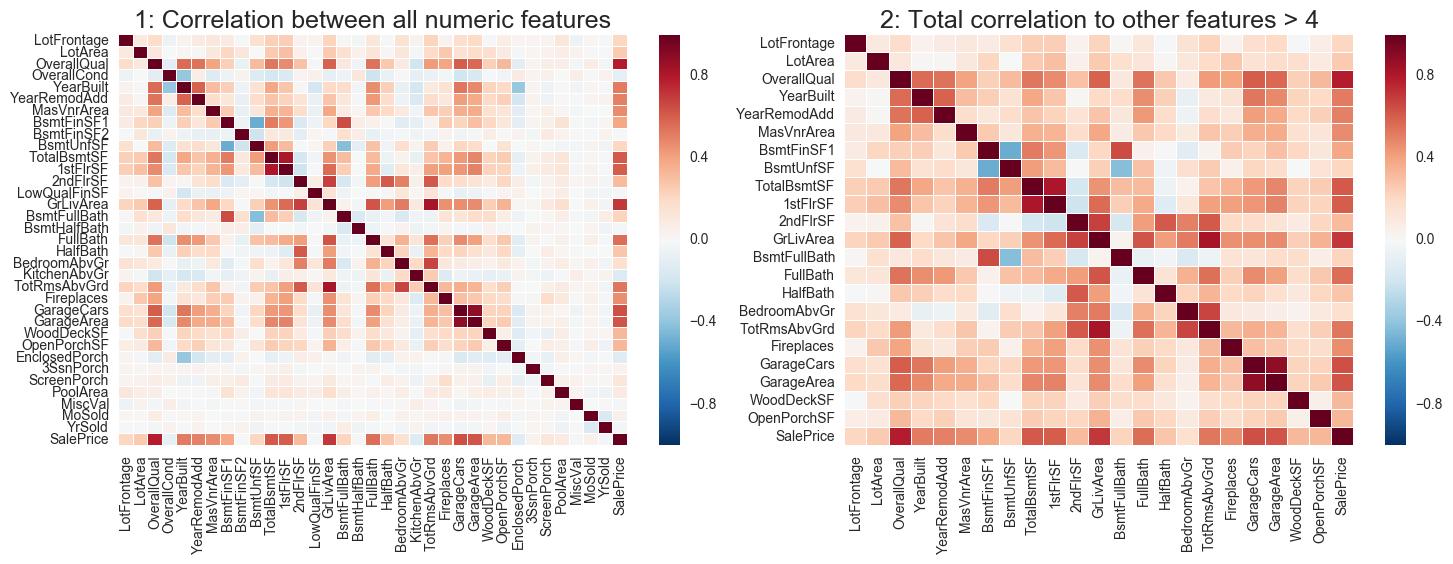

In [83]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,c_threshold = 0)
plt.title('1: Correlation between all numeric features', fontsize = 18)

plt.subplot(2,2,2)
plt.title('2: Total correlation to other features > 4', fontsize = 18)
plot_heatmatp(df,c_threshold = 4)
plt.tight_layout()

plt.show()

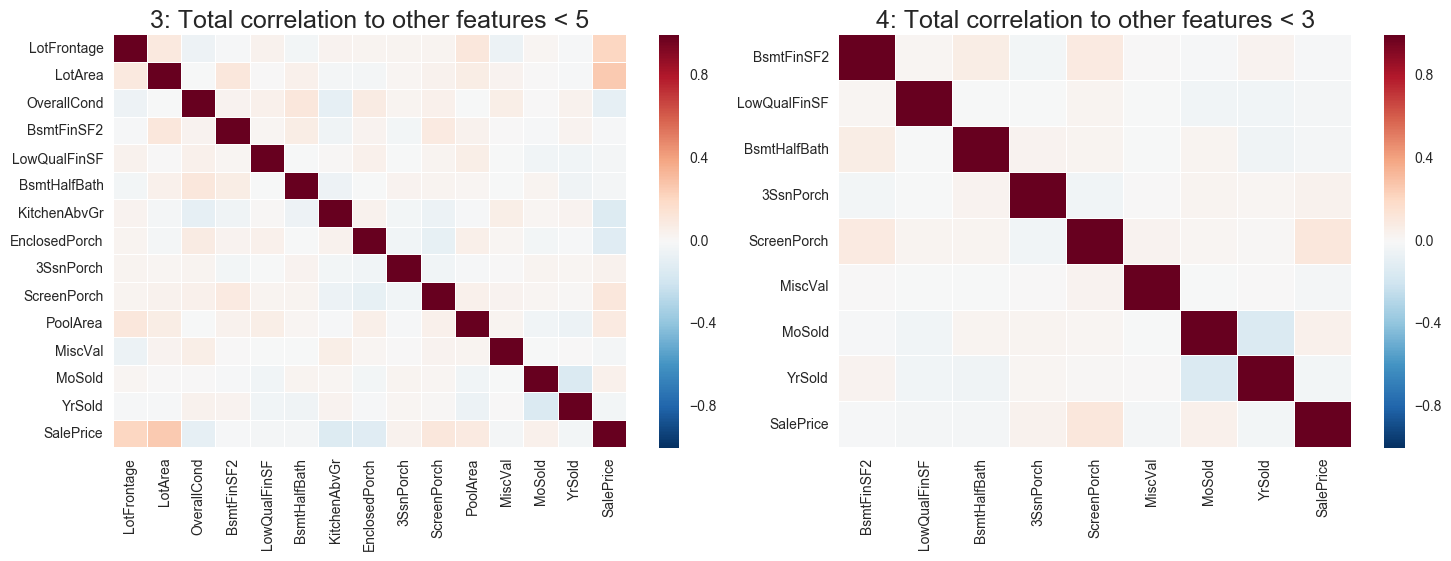

In [84]:
plt.clf()
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,c_threshold = 5,weak = -1, target='SalePrice')
plt.title('3: Total correlation to other features < 5', fontsize = 18)

plt.subplot(2,2,2)
plt.title('4: Total correlation to other features < 3', fontsize = 18)
plot_heatmatp(df,c_threshold = 3, weak = -1,target='SalePrice')
plt.tight_layout()

plt.show()

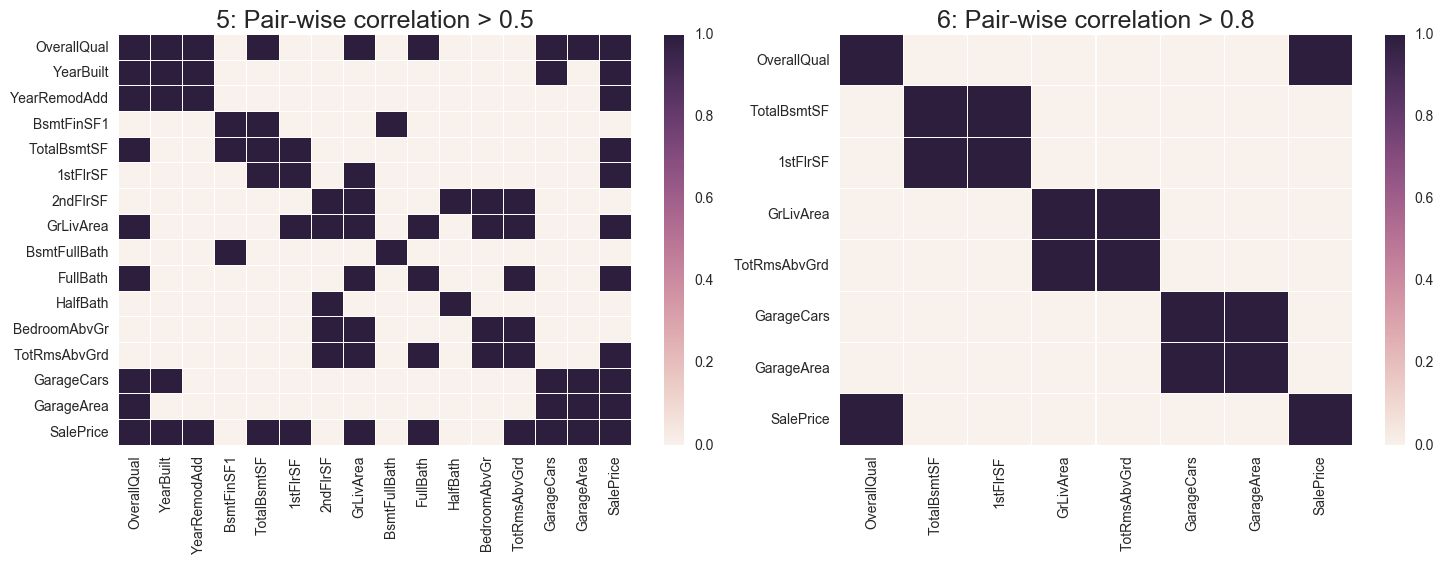

In [85]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,threshold=0.5)
plt.title('5: Pair-wise correlation > 0.5', fontsize = 18)

plt.subplot(2,2,2)
plt.title('6: Pair-wise correlation > 0.8', fontsize = 18)
plot_heatmatp(df,threshold=0.75)
plt.tight_layout()

plt.show()

We draw four key conclusions from these heatmaps:

    1. We certainly have strongly correlated features such as 
    
            GarageCars with GarageArea
            GrLivArea  with TotRmsAbvGrd
            OveralQual with SalePrice
            
    2. Some features are indeed weakely pairwise correlated with all other features. 
       We can see this in figures 3 and 4, and this provides further justification for 
       the category of 'Incidental Attribute'.
       
The slightly negative correlation between the month of sale and the year of sale drew our attention to the slight negative skew of the MoSold distribution (which uses a numeric code of 1-12). From this we draw 

    3. We certainly have features in our data whose impact on the price 
       could not possibly be reflected in a linear or even quadratic model. 
       
    4. Realestate firms should expect their services to be needed most in June, 
       and least in September. 

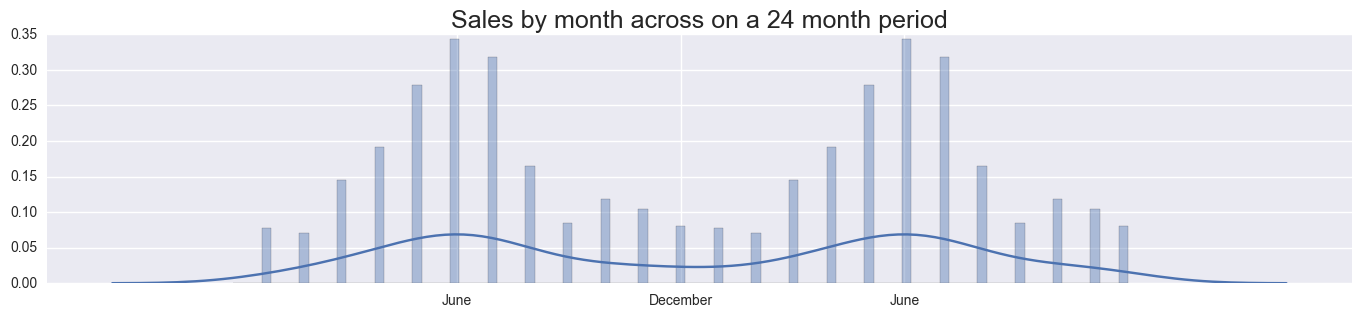

In [86]:
plt.figure(figsize=(15,3))
a_year = df['MoSold'].values
dates = np.concatenate([a_year,a_year+12])

bins = np.linspace(0,24,96)
sns.distplot(dates,bins=bins,norm_hist=True)
plt.xticks([6,12,18],['June','December','June'])
plt.title('Sales by month across on a 24 month period', fontsize = 18)

plt.show()

## 3. Feature selection and Classification

_This is NOT the section where we select our best model, here we use linear regression merely as a tool for feature selection._

Before we begin developing a model for sale price, we take a moment to explore the 'redundancy' in our data. As we shall see, several attributes of a sale are merely linear combinations of other attributes. We can identify these situations for numeric features by by setting $x_i$ as the target of a plain linerar regression using features $x_1,...x_{i-1},-\square-,x_{i+1},...,x_{n}$ to predict the values of $x_i$. If $x_i$ is in the span the other features we should observe a mean square error of 0, and hence an $\text{R}^2$ value of 1.

In [220]:
# We separate our features into those that are numeric and those that are categorical.
numeric = df.describe().columns.tolist()
categoric = [col for col in df.columns if col not in numerics]

In [263]:
def naive_lm_predict(df,attributes,ignore = None ,verbose = 0, test_set = 1):
    coef_storage = {}
    results = []
    if verbose > 1: print('Predicting:\n{}'.format('_'*_chars_per_line))
    
    for col in attributes:
        X,y = getXy(df,target=col,ignore_colums=ignore)
        if verbose > 2: 
            print((str(col).ljust(14)+ ' on {} features.'.format(X.shape[1])))
        elif verbose > 1:
            print(str(col), end='|')

        # create masks for a train test split when a test boolean list is passed, 
        # or initialize the trivial mask.
        if  type(test_set) == int: 
            test = [True]*y.count()
            train = [True]*y.count()
        else:
            test = test_set
            train = [not i for i in test_set]
            
        lm = LinearRegression()
        lm.fit(X[train],y[train])
        score = lm.score(X[test],y[test]) 
        coef_storage[col] = pd.DataFrame({'atr':X.columns, 'coef':lm.coef_})
        
        results.append(col.ljust(14)+':'+str(round(score,4)))
        
        if verbose == -1: 
            print('Predicted {} on {} features, scored {}'.format(col,X.shape[1], round(score,4)))

    if verbose > 0: plist(results,col_num=4,spacing=24,title='\n\nResults')
    return (results, coef_storage)

In [270]:
_ = naive_lm_predict(df, numeric, verbose=2)

Predicting:
_____________________________________________________________________________________________________________________
LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|

Results:
_____________________________________________________________________________________________________________________
LotFrontage   :0.5066   LotArea       :0.7495   OverallQual   :0.8532   OverallCond   :0.6922   
YearBuilt     :0.9552   YearRemodAdd  :0.7741   MasVnrArea    :0.7124   BsmtFinSF1    :1.0      
BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0     

Reflecting on the results above guides much of what follows. So let us transcribe the results for ease of reference:

    LotFrontage   :0.5066   LotArea       :0.7495   OverallQual   :0.8532   OverallCond   :0.6922   
    YearBuilt     :0.9552   YearRemodAdd  :0.7741   MasVnrArea    :0.7124   BsmtFinSF1    :1.0      
    BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
    2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0      BsmtFullBath  :0.7041   
    BsmtHalfBath  :0.3905   FullBath      :0.7929   HalfBath      :0.7168   BedroomAbvGr  :0.7697   
    KitchenAbvGr  :0.8373   TotRmsAbvGrd  :0.8719   Fireplaces    :0.8897   GarageCars    :0.8926   
    GarageArea    :0.8885   WoodDeckSF    :0.4126   OpenPorchSF   :0.4706   EnclosedPorch :0.4818   
    3SsnPorch     :0.2449   ScreenPorch   :0.357    PoolArea      :0.9963   MiscVal       :0.9685   
    MoSold        :0.2733   YrSold        :0.3514   SalePrice     :0.939    


We can observe many interesting things to examing further. And incidentaly we can verify that for each of the 1450 properties:

$$\text{TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF}$$

$$\text{GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF}$$

Moving forwards we **drop** the LowQualFinSF and BsmtUnfSF attributes since we know we can deduce them from the remaining features.

In [261]:
df_wd1= df.drop(['LowQualFinSF','BsmtUnfSF'], axis=1)

numeric_wd1 = [col for col in numeric if col not in ['LowQualFinSF','BsmtUnfSF']]
categoric_wd1 = categoric

At this time we are ready to tackle the issue of the GarageYrBlt attribute. For the 37 properties we encountered without a garage, no reasonable way came to mind to codify a missing year.

As the focusing soley on the $R^2$ valye in the folowing naive approach might indicate, including the column in its categorical form might result in a better model.

In [265]:
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore= None, verbose=-1)
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore=['GarageYrBlt'],verbose=-1)

Predicted SalePrice on 410 features, scored 0.939
Predicted SalePrice on 313 features, scored 0.9335


However, turning the year in which the garage was built into a categorical variable is a terrible idea for a myriad of reasons. The top 3 that come to mind are:

    1. Due to the many unique values pressent in the attribute, the number of records corresponding to each 
       would-be category will be too small for us to have any faith in the learned parameters.
       
    2. Our model would be terrible at dealing with new houses or new garages of any kind since all houses built 
       after our model has been fitted will - inevitably - fall into none of the categories present in the 
       training data.
       
    3. Having only 1450 records in our dataset as a while, properties in total, increasing the 
       dimensionality of our model is not something we should be take lightly.
       
We have certainly made up our minds to drop the attribute, but we may take this chance to explore the concept of Bias-Variance tradeoff.

As we can see in the output above, disregarding the GarageYrBlt category would reduce our number of features in a very significant manner. 

Not only will this most likely reduce our model variance, but we suspect that the inclussion of GarageYrBlt does not lead to a significantly lower bias either. We've made up our minds to **drop** GarageYrBlt, but it is quick enough to confirm our intuition by looking at the $R^2$ values when we do a simple 80/20 test train split.

In [268]:
np.random.seed(42)
tester = np.random.rand(df_wd1.shape[0]) > 0.8
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore= None, verbose=-1,test_set = tester)
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore=['GarageYrBlt'],verbose=-1,test_set = tester)

Predicted SalePrice on 410 features, scored 0.8665
Predicted SalePrice on 313 features, scored 0.8705


In [269]:
# we drop GarageYrBlt
df_wd2= df_wd1.drop(['GarageYrBlt'], axis=1)

numeric_wd2 = numeric_wd1
categoric_wd2 = [col for col in categoric_wd1 if col not in ['GarageYrBlt']]

_ = naive_lm_predict(df_wdrops, numeric_d1,verbose=2,ignore=['GarageYrBlt'])

    Results: 313
    _____________________________________________________________________________________________________________________
    LotFrontage   :0.4574   LotArea       :0.7219   OverallQual   :0.8318   OverallCond   :0.6436   
    YearBuilt     :0.9443   YearRemodAdd  :0.7318   MasVnrArea    :0.6882   BsmtFinSF1    :0.8355   
    BsmtFinSF2    :0.7962   TotalBsmtSF   :0.9261   1stFlrSF      :0.9943   2ndFlrSF      :0.995    
    GrLivArea     :0.9968   BsmtFullBath  :0.6737   BsmtHalfBath  :0.333    FullBath      :0.7651   
    HalfBath      :0.6898   BedroomAbvGr  :0.7376   KitchenAbvGr  :0.8127   TotRmsAbvGrd  :0.859    
    Fireplaces    :0.8728   GarageCars    :0.8807   GarageArea    :0.8714   WoodDeckSF    :0.3592   
    OpenPorchSF   :0.4338   EnclosedPorch :0.4121   3SsnPorch     :0.188    ScreenPorch   :0.2904   
    PoolArea      :0.9959   MiscVal       :0.966    MoSold        :0.2123   YrSold        :0.2577   
    SalePrice     :0.9335   

In [168]:
compare = pd.merge(resres[1]['GrLivArea'],reoniggr[1]['GrLivArea'], on='atr')
compare.sort_values(by = 'coef_x')

atr      coef_x      coef_y
276                 GarageCond_Ex -226.243359 -219.151577
284       PoolQC_DescribesMissing -143.591572 -248.472810
294              MiscFeature_None -108.500605  -98.102391
113               Condition2_RRAe -103.516997 -114.665050
122             HouseStyle_1.5Unf  -89.503744  -36.732244
123             HouseStyle_1Story  -87.870263  -89.266611
296              MiscFeature_Shed  -81.559303  -70.533942
134                RoofStyle_Shed  -76.520258  -66.441629
127             HouseStyle_SFoyer  -67.449950  -65.339726
239                Electrical_Mix  -67.328207  -53.657171
297              MiscFeature_TenC  -60.987577  -96.456517
117               BldgType_2fmCon  -58.918408  -43.843213
273                 GarageQual_Po  -57.056550  -62.759441
128               HouseStyle_SLvl  -55.443606  -54.952219
272                 GarageQual_Gd  -53.811723  -52.637615
274                 GarageQual_TA  -48.579938  -46.730975
271                 GarageQual_Fa  -47.873441  -44.903441
226                  Heating_Grav  -47.669743  -47.988469
42        MSSubClass_2S_PUD_>1946  -43.609399  -34.537041
39                MSSubClass_2.5S  -40.288819   -3.045640
170            Exterior2nd_Stucco  -39.946814  -15.116101
202                   BsmtCond_Po  -38.804946  -46.166748
138                RoofMatl_Metal  -33.993374   -6.343634
248               Functional_Min2  -31.443556  -26.263134
44              MSSubClass_PUD_ML  -29.309628  -22.788673
32       MSSubClass_1.5S_FINISHED  -28.372869  -28.420908
224                  Heating_GasA  -25.949714  -25.879076
163           Exterior2nd_CmentBd  -25.494504  -20.312878
76            Neighborhood_BrDale  -25.163376  -19.203630
65               Utilities_NoSeWa  -25.097263  -34.008031
..                            ...         ...         ...
192              Foundation_Stone   19.040310   25.126142
52                    Street_Pave   19.419554   17.464391
75           Neighborhood_Blueste   20.553229    7.109041
148           Exterior1st_CemntBd   21.518912   12.495663
172           Exterior2nd_Wd_Sdng   23.174360   17.139663
245               Functional_Maj1   23.864606   17.277604
64               Utilities_AllPub   25.097263   34.008031
78           Neighborhood_ClearCr   25.678819   23.874534
131             RoofStyle_Gambrel   25.794514   19.621578
120               BldgType_TwnhsE   26.319238   17.566344
119                BldgType_Twnhs   27.757805   19.106887
139                 RoofMatl_Roll   30.069964   10.561444
154            Exterior1st_Stucco   31.926196   20.657214
180                  ExterQual_Fa   33.169114   32.269412
108             Condition2_Artery   33.212748    8.973026
280                 GarageCond_TA   41.498155   44.055481
238              Electrical_FuseP   43.469620   41.835393
277                 GarageCond_Fa   43.628224   45.743960
38                MSSubClass_2_FC   50.048810   38.237612
92             Neighborhood_SWISU   51.885246   41.879006
111               Condition2_PosA   59.436375   52.099683
278                 GarageCond_Gd   62.004844   61.054753
246               Functional_Maj2   73.230360   86.163799
279                 GarageCond_Po   76.688981   63.355908
227                  Heating_OthW   94.189244   98.857111
36   MSSubClass_1S_FINISHED_ATTIC  109.263936  111.760327
285                     PoolQC_Ex  166.435459  227.109663
270                 GarageQual_Ex  204.898498  202.089997
293              MiscFeature_Gar2  272.283641  280.712571
124             HouseStyle_2.5Fin  331.125212  306.669373

[313 rows x 3 columns]

_ = naive_lm_predict(df_wdrops, numeric_d1,verbose=2)

Results: on 410 features
_____________________________________________________________________________________________________________________
LotFrontage   :0.5066   LotArea       :0.7495   OverallQual   :0.8532   OverallCond   :0.6922   
YearBuilt     :0.9552   YearRemodAdd  :0.7741   MasVnrArea    :0.7124   BsmtFinSF1    :0.8462   
BsmtFinSF2    :0.8123   TotalBsmtSF   :0.9317   1stFlrSF      :0.9949   2ndFlrSF      :0.9955   
GrLivArea     :0.9971   BsmtFullBath  :0.7041   BsmtHalfBath  :0.3905   FullBath      :0.7929   
HalfBath      :0.7168   BedroomAbvGr  :0.7697   KitchenAbvGr  :0.8373   TotRmsAbvGrd  :0.8719   
Fireplaces    :0.8897   GarageCars    :0.8926   GarageArea    :0.8885   WoodDeckSF    :0.4126   
OpenPorchSF   :0.4706   EnclosedPorch :0.4818   3SsnPorch     :0.2449   ScreenPorch   :0.357    
PoolArea      :0.9963   MiscVal       :0.9685   MoSold        :0.2733   YrSold        :0.3514   
SalePrice     :0.939    

In [160]:
resres[1]['YearBuilt']

atr       coef
0                LotFrontage   0.007313
1                    LotArea  -0.000101
2                OverallQual   1.003175
3                OverallCond  -2.661807
4               YearRemodAdd   0.053722
5                 MasVnrArea  -0.000547
6                 BsmtFinSF1  -0.001046
7                 BsmtFinSF2  -0.002764
8                TotalBsmtSF   0.006035
9                   1stFlrSF  -0.006780
10                  2ndFlrSF  -0.004494
11                 GrLivArea  -0.003485
12              BsmtFullBath  -0.051691
13              BsmtHalfBath  -0.765267
14                  FullBath   2.325546
15                  HalfBath   3.595747
16              BedroomAbvGr   1.484527
17              KitchenAbvGr  -4.495668
18              TotRmsAbvGrd  -0.391882
19                Fireplaces  -0.709150
20                GarageCars  -0.221199
21                GarageArea   0.000869
22                WoodDeckSF  -0.000043
23               OpenPorchSF  -0.003521
24             EnclosedPorch  -0.023999
25                 3SsnPorch  -0.002399
26               ScreenPorch  -0.009792
27                  PoolArea   0.081988
28                   MiscVal  -0.001685
29                    MoSold   0.024277
..                       ...        ...
380             PavedDrive_Y   4.620195
381  PoolQC_DescribesMissing  40.006198
382                PoolQC_Ex -12.905071
383                PoolQC_Fa -19.053237
384                PoolQC_Gd  -8.047890
385              Fence_GdPrv  -1.200812
386               Fence_GdWo   1.995723
387              Fence_MnPrv  -0.633152
388               Fence_MnWw  -0.207687
389               Fence_None   0.045928
390         MiscFeature_Gar2  16.544945
391         MiscFeature_None -11.711377
392         MiscFeature_Othr  -4.692807
393         MiscFeature_Shed -10.559881
394         MiscFeature_TenC  10.419120
395             SaleType_COD  -0.665523
396             SaleType_CWD  -2.484728
397             SaleType_Con  -1.324585
398           SaleType_ConLD   1.010384
399           SaleType_ConLI  -3.492767
400           SaleType_ConLw   0.725781
401             SaleType_New   0.654260
402             SaleType_Oth   7.205415
403              SaleType_WD  -1.628236
404    SaleCondition_Abnorml   2.478316
405    SaleCondition_AdjLand  -9.917999
406     SaleCondition_Alloca   3.848513
407     SaleCondition_Family  -0.368263
408     SaleCondition_Normal   2.617544
409    SaleCondition_Partial   1.341888

[410 rows x 2 columns]

In [136]:
X1,X2,y1,y2 = getXy(df,ignore_colums=['BsmtUnfSF','LowQualFinSF'],train_test=True)  ## code it as test = [bool array]

In [137]:
lm = LinearRegression()
lm.fit(X1,y1).score(X2,y2)

0.90675994666940274

In [28]:
def naive_logreg_predict(attributes, myC = 10**10, ignore= None):
    coef_storage = {}
    results = []
    print('Predicting:\n{}'.format('_'*_chars_per_line))
    for col in attributes:
        print(col, end='; ')
        X,y = getXy(df,target=col, ignore_colums= ignore)
        logreg = LogisticRegression(C = myC)
        logreg.fit(X,y)
        score = logreg.score(X,y) 
        results.append(col.ljust(14)+':'+str(round(score,4)))
    print('\n\nResults:\n{}'.format('_'*_chars_per_line))
    plist(results,col_num=4,spacing=24)
    return (results, coef_storage)

naive_logreg_predict(categoric)

The corresponding output is:

    Predicting:
    __________________________________________________________________________________________________________
    MSSubClass; MSZoning; Street; Alley; LotShape; LandContour; Utilities; LotConfig; LandSlope; Neighborhood;
    Condition1; Condition2; BldgType; HouseStyle; RoofStyle; RoofMatl; Exterior1st; Exterior2nd; MasVnrType;
    ExterQual; ExterCond; Foundation; BsmtQual; BsmtCond; BsmtExposure; BsmtFinType1; BsmtFinType2; Heating;
    HeatingQC; CentralAir; Electrical; KitchenQual; Functional; FireplaceQu; GarageType; GarageYrBlt; GarageFinish;
    GarageQual; GarageCond; PavedDrive; PoolQC; Fence; MiscFeature; SaleType; SaleCondition; 

    Results:
    _____________________________________________________________________________________________
    MSSubClass    :0.8159   MSZoning      :0.8759   Street        :1.0      Alley         :0.9393   
    LotShape      :0.7131   LandContour   :0.9062   Utilities     :1.0      LotConfig     :0.7234   
    LandSlope     :0.9531   Neighborhood  :0.4966   Condition1    :0.8621   Condition2    :0.9938   
    BldgType      :0.9034   HouseStyle    :0.8628   RoofStyle     :0.8076   RoofMatl      :0.9848   
    Exterior1st   :0.5124   Exterior2nd   :0.4834   MasVnrType    :0.8793   ExterQual     :0.8807   
    ExterCond     :0.8821   Foundation    :0.8028   BsmtQual      :0.8269   BsmtCond      :0.9241   
    BsmtExposure  :0.7021   BsmtFinType1  :0.6731   BsmtFinType2  :0.9379   Heating       :0.9834   
    HeatingQC     :0.6248   CentralAir    :0.9538   Electrical    :0.9152   KitchenQual   :0.7855   
    Functional    :0.9317   FireplaceQu   :0.6207   GarageType    :0.7972   GarageYrBlt   :0.3021   
    GarageFinish  :0.6634   GarageQual    :0.9559   GarageCond    :0.9641   PavedDrive    :0.9276   
    PoolQC        :1.0      Fence         :0.8097   MiscFeature   :0.9972   SaleType      :0.891    
    SaleCondition :0.8421   


In [29]:
ress = {}
for col in X.columns:
     ress[col] = naive_lm_predict(['SalePrice'], ignore = [col])[1]

ress

NameError: name 'X' is not defined

In [ ]:
X,y = implement_modeling(df, target='TotalBsmtSF',ignore_colums=decide_to_ignore)

lm.fit(X,y)

pd.DataFrame({'atr':X.columns,'coef':lm.coef_})

In [ ]:
categorical = [col for col in df.columns if col not in df.describe().columns and col not in incidental]
df.plot_value_occurences(columns=categorical, mn = (7,6))

In [ ]:
paramgrid = {'alpha':np.logspace(-4,4,3)}

ridge = Ridge()
gs = GridSearchCV(ridge, 
                  param_grid=paramgrid,
                  cv = 2, 
                  n_jobs=3, 
                  verbose=4)

A,B = implement_modeling(df, ignore_colums=decide_to_ignore)

gs.fit(A,B)



In [ ]:
ridge.fit(A,B)

Further inspection reveals that all but one of the properties has access to all public 

In [ ]:
kfixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities',
          'LandSlope','LotConfig','Neighborhood','Condition1','Condition2','YearBuilt','YearRemodAdd','RoofStyle',
          'MasVnrType','MasVnrArea','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1','BsmtFinSF2','Heating',
          '2ndFlrSF','KitchenAbvGr','Fireplaces','GarageType','GarageCars','GarageArea']

kalterable = ['RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond','BsmtCond','BsmtFinType1',
              'BsmtFinType2','BsmtUnfSF','HeatingQC','CentralAir','Electrical','1stFlrSF','GrLivArea',
              'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','Bedroom','KitchenQual','TotRmsAbvGrd',
              'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence',
              'MiscFeature','MiscVal']

    
kderivative = ['BldgType','HouseStyle','OverallQual','OverallCond','LowQualFinSF','TotalBsmtSF']

kincidental = ['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

len(kalterable + kfixed +kderivative +kincidental)

In [ ]:

kincidental == incidental

[f for f in kfixed if f not in fixed]

In [ ]:
fixed = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
         'LandContour',  'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
         'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
         'Foundation', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
         'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
         'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea']

incidental = ['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

alterable = [col for col in df.columns if col not in fixed and col not in incidental]

print('\nFixed:\n{}'.format('_'*_chars_per_line))
plist(fixed)
print('\nAlterable:\n{}'.format('_'*_chars_per_line))
plist(alterable)
print('\nIncidental:\n{}'.format('_'*_chars_per_line))
plist(incidental)

However, we do not consider it possible to alter the value of an attribute when it relates to an aspect of the house that is not present. As such, we frown on the idea of improving the PoolQC in a house where PoolArea is 0 and the like.

At this time we have not implemented a check in our code that prevents a user from speculating, and the linear model we implement will not distinguish between valid and nonsensical speculation. User caution is adviced.

This very much pushes us to examine attributes with missing values before moving forwards.

When possible we NaN with 0, such as when describing the length of pavement 

We establish a convention: 

    1. We use 'NotPresent' to indicate the physical absence of a feature.
        eg. The Alley attribute that states the type of alley leading up to the house will have:
           Grvl          When it is a gravel road
           Pave          When it is a paved road
           NotPresent    When there is no alley leading up to the house
        
    2. We use 'NotApplicable' to indicate a metaphysical absence, such as the quality of a missing feature.
        eg. The quality of a pool when the house has no pool


In [ ]:
df.plot_value_occurences(columns=df.columns.tolist()[0:17])

In [ ]:
df_data_cleaning.set_checkpoint()

In [ ]:
for col in [col for col in df.columns if types_df[col]["<class 'str'>"] > 0]:
    print(col+':')
    plist(df[col].unique(), spacing=10,rstart = '> ')
    print()

In [ ]:

    
class DataExplorer(DataFrameHelper):

    def explore_correlation(self,):
        sns.regplot(self[cols],y,order=2)

        

In [ ]:
df1 = DataExplorer(df)

In [ ]:
test = (df['YrSold'] == 2010).values
train = (df['YrSold'] != 2010).values

In [ ]:
dat = pd.DataFrame()
for st in [None,'S','M']:
    for it in [True,False]:
        dat = pd.concat([dat,implement_modeling(df,model='lasso',
                                               consider_columns = fixed,
                                               get_dummies=True,
                                               scale_technique=st,
                                               internal_norm = it).to_df()])


dat

In [ ]:
implement_modeling(df,model='ridge',scale_technique='M',
                   consider_columns = fixed,
                   get_dummies=True).to_df()

In [ ]:
implement_modeling(df,model='ridge',scale_technique=None,
                   consider_columns = fixed,
                   get_dummies=True).to_df()

In [ ]:
implement_modeling(df,model='ridge',scale_technique=None,
                   consider_columns = fixed,
                   get_dummies=True,
                   internal_norm = True).to_df()

In [ ]:
parameter_space = {model:['lm','ridge','lasso'],
                    {alpha : [0.1,1,10,100],
        for consider_col in [fixed]:
            for scale_technique in [None,'S','M']:
                for ddf in [True,False]:

def hyper_parameter_explorer(di)
    for 

In [ ]:
dat = pd.DataFrame()
for mod in ['ridge']:
    for alpha in [0.1,1,10,100]:
        for consider_col in [fixed]:
            for scale_technique in [None,'S','M']:
                for ddf in [True,False]:
                    
                    key = (mod.rjust(7)
                       +' alpha='+str(round(alpha,3)).rjust(4)
                       +' Scaled by '+str(scale_technique).rjust(5)
                       +' Dropping frist: '+str(ddf).rjust(5))
                    print (key)
                    
                    report = implement_modeling(df1,model=mod,consider_columns=consider_col,
                                                scale_technique = scale_technique,model_alpha=alpha,
                                                do_drop_first = ddf)
                    
                    dat = pd.concat([dat, report.to_df()],axis=0)

In [ ]:
dat.reset_index().sort_values('cv_score')

In [ ]:
sort = sorted([(di[key].true_score.round(4),key) for key in di.keys()])
for (x,y) in sort: print(y,x)

In [ ]:
for i in range(100):
    k=np.sqrt(i)
    print (i,np.floor(k+1) * np.floor(k))

(0.85340352664490027, 'ridge10None')

0.85426008217280969 ridge10None after!!!

(0.87057883511318945, 'ridge10None')]


    (0.87057883511318945, 'ridge10NoneTrue'),
    (0.87113126001225183, 'ridge10NoneFalse')]


    (0.87057883511318945, 'ridge10NoneTrue'),
     (0.87113126001225183, 'ridge10NoneFalse') worked better than alpha = 100


before altering the qual to num:

        (0.8671087710751757, 'ridge alpha=100 Scaled by S Dropping frist: False'),
     (0.87057883511318945, 'ridge alpha=10 Scaled by None Dropping frist: True'),
     (0.87113126001225183, 'ridge alpha=10 Scaled by None Dropping frist: False')]
     
after 

     (0.8671087710751757, 'ridge alpha=100 Scaled by S Dropping frist: False'),
     (0.87057883511318945, 'ridge alpha=10 Scaled by None Dropping frist: True'),
     (0.87113126001225183, 'ridge alpha=10 Scaled by None Dropping frist: False')]


In [ ]:
datatat = pd.read_csv('../project-02/housing.csv')


In [ ]:
pd.DataFrame(datatat.dtypes.value_counts(dropna=False))

In [ ]:
pd.DataFrame(datatat.isnull().sum())

In [ ]:
pd.DataFrame(datatat.applymap(type)).unique().T

In [ ]:
{k:{key:datatat[key].apply(type).value_counts(dropnan=False) for key in datatat.columns} for }

In [ ]:
pd.DataFrame({key:datatat[key].apply(extended_type).value_counts(dropna = False) for key in datatat.columns})

https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

In [ ]:
incidental<sup>[1](#myfootnote1)</sup>.
<a name="myfootnote1">1</a>: This is a footnote

In [ ]:
for col in examine_closer_str:
    print(col+':\n{}'.format('_'*115))
    plist(df[col].unique(), spacing=14,col_num=9)
    print()
    
for col in examine_closer_str:
    print(col+':\n{}'.format('_'*115))
    plist(df[col].value_counts(dropna=False), spacing=14,col_num=9)
    print()
    
for col in examine_closer_str:
    print(col+':\n{}'.format('_'*115))
    plist(list(zip(df[col].unique(),df[col].value_counts(dropna=False))), spacing=16,col_num=9)
    print()

In [ ]:
[print(i) for i in range(5)]

Reflecting on the results above guides much of what follows. So let us transcribe the R^2 we for ease of reference:

    LotFrontage   :0.4574   LotArea       :0.7219   OverallQual   :0.8318   OverallCond   :0.6436   
    YearBuilt     :0.9443   YearRemodAdd  :0.7318   MasVnrArea    :0.6882   BsmtFinSF1    :1.0      
    BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
    2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0      BsmtFullBath  :0.6737   
    BsmtHalfBath  :0.333    FullBath      :0.7651   HalfBath      :0.6898   BedroomAbvGr  :0.7376   
    KitchenAbvGr  :0.8127   TotRmsAbvGrd  :0.859    Fireplaces    :0.8728   GarageCars    :0.8807   
    GarageArea    :0.8714   WoodDeckSF    :0.3592   OpenPorchSF   :0.4338   EnclosedPorch :0.4121   
    3SsnPorch     :0.188    ScreenPorch   :0.2904   PoolArea      :0.9959   MiscVal       :0.966    
    MoSold        :0.2123   YrSold        :0.2577   SalePrice     :0.9335   


## Since the above was typed a few hours ago, I cleaned the data further. We now see the following results (maybe I accidentaly cast my GarageBldYr as a category? NO):

    LotFrontage   :0.5066   LotArea       :0.7495   OverallQual   :0.8532   OverallCond   :0.6922   
    YearBuilt     :0.9552   YearRemodAdd  :0.7741   MasVnrArea    :0.7124   BsmtFinSF1    :1.0      
    BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
    2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0      BsmtFullBath  :0.7041   
    BsmtHalfBath  :0.3905   FullBath      :0.7929   HalfBath      :0.7168   BedroomAbvGr  :0.7697   
    KitchenAbvGr  :0.8373   TotRmsAbvGrd  :0.8719   Fireplaces    :0.8897   GarageCars    :0.8926   
    GarageArea    :0.8885   WoodDeckSF    :0.4126   OpenPorchSF   :0.4706   EnclosedPorch :0.4818   
    3SsnPorch     :0.2449   ScreenPorch   :0.357    PoolArea      :0.9963   MiscVal       :0.9685   
    MoSold        :0.2733   YrSold        :0.3514   SalePrice     :0.939    

### Rerunning it just again with ignore = ['GarageYrBuilt'] yeilded the same results

### Running on just the numeric features (34):

    LotFrontage   :0.1344   LotArea       :0.1865   OverallQual   :0.7257   OverallCond   :0.3741   
    YearBuilt     :0.7569   YearRemodAdd  :0.5554   MasVnrArea    :0.29     BsmtFinSF1    :1.0      
    BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
    2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0      BsmtFullBath  :0.5494   
    BsmtHalfBath  :0.1262   FullBath      :0.6526   HalfBath      :0.5403   BedroomAbvGr  :0.5697   
    KitchenAbvGr  :0.2929   TotRmsAbvGrd  :0.7974   Fireplaces    :0.3639   GarageCars    :0.8191   
    GarageArea    :0.8093   WoodDeckSF    :0.1785   OpenPorchSF   :0.1922   EnclosedPorch :0.2173   
    3SsnPorch     :0.0207   ScreenPorch   :0.1038   PoolArea      :0.0876   MiscVal       :0.0266   
    MoSold        :0.0468   YrSold        :0.0486   SalePrice     :0.8058   


In [196]:
df['SalePrice'].count()

1450

In [198]:
y.count()

1450

In [239]:
testing = [True,False,True]

In [203]:
test*-1

[]

In [240]:
testing == None

False

In [241]:
testing != None

True

In [251]:
type(None)

NoneType